## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
import shap
from lime.lime_tabular import LimeTabularExplainer

from IPython.display import HTML

d:\Workspace\airline-booking\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Globals & Constants

In [2]:
sns.set_theme(style='whitegrid', font='consolas', palette='crest')
shap.initjs()

## Utility Functions

In [3]:
def clean_text(df: pd.DataFrame) -> None:
    object_cols = df.select_dtypes(include='object')

    df[object_cols.columns] = df[object_cols.columns].apply(lambda x: x.str.strip())

def dedupe(df: pd.DataFrame) -> None:
    before = len(df)
    df.drop_duplicates(inplace=True)
    
    print(f"Number Of Dropped Duplicates: {before - len(df)}")

def explore_numeric_cols(df: pd.DataFrame) -> None:
    numeric_cols = df.select_dtypes(exclude='object')

    display(numeric_cols.describe())

    figure, axes = plt.subplots(nrows=len(numeric_cols.columns), ncols=2, figsize=(10, 3 * len(numeric_cols.columns)))
    figure.subplots_adjust(hspace=0.4)

    for i, column in enumerate(numeric_cols.columns):
        sns.histplot(df[column], kde=True, ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f'{column} Distribution')
        
        sns.boxplot(x=df[column], ax=axes[i, 1], color='salmon')
        axes[i, 1].set_title(f'{column} Boxplot')

    plt.tight_layout()
    display(plt.show())

    display(sns.heatmap(numeric_cols.corr()))

def explore_object_cols(df: pd.DataFrame) -> None:
    object_cols = df.select_dtypes(include='object')

    display(object_cols.describe())
    
    for column in object_cols:
        print(f' {column} '.center(50, "="))

        modes = df[column].value_counts().nlargest(10)
        values = [str(value)[:30] + ('...' if len(str(value)) > 30 else '') for value in modes.index]

        for (value, mode) in zip(values, modes):
            print(f'{value:<40} {mode}')
        print()

def explore_na(df: pd.DataFrame) -> None:
    display(df.isnull().sum())
    display(msno.matrix(df))

def explore_history(history):
    plt.plot(history.history['loss'], label='Train Loss', color='black')
    plt.plot(history.history['val_loss'], label='Val Loss', color='black', linestyle='--')

    plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green', linestyle='--')

    plt.plot(history.history['precision'], label='Train Precision', color='blue')
    plt.plot(history.history['val_precision'], label='Val Precision', color='blue', linestyle='--')

    plt.plot(history.history['recall'], label='Train Recall', color='red')
    plt.plot(history.history['val_recall'], label='Val Recall', color='red', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Training Progress (Accuracy, Precision, Recall)')
    plt.legend()
    display(plt.show())

def evaluate_metrics(model, X_test, y_test) -> None:
    y_pred = (model.predict(X_test) >= 0.5).astype(int)

    loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    display(plt.show())

    print(classification_report(y_test, y_pred))

def wrap_predict(predict):
    def wrapped_predict(X):
        pred = predict(X)
        
        return np.hstack((1 - pred, pred))
    
    return wrapped_predict

## Data Processing

### Reviews Table Data Processing

#### Reviews Table Data Exploration

In [4]:
reviews_df = pd.read_csv('raw_dataset/AirlineScrappedReview_Cleaned.csv')

In [5]:
clean_text(reviews_df)
dedupe(reviews_df)

Number Of Dropped Duplicates: 74


In [6]:
display(reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3501 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3500 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2807 non-null   object 
 3   Rating           3501 non-null   int64  
 4   Verified         3501 non-null   object 
 5   Review_title     3501 non-null   object 
 6   Review_content   3501 non-null   object 
 7   Traveller_Type   3501 non-null   object 
 8   Class            3501 non-null   object 
 9   Start_Location   2807 non-null   object 
 10  End_Location     2807 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3441 non-null   float64
 13  Start_Longitude  3441 non-null   float64
 14  Start_Address    3441 non-null   object 
 15  End_Latitude     3402 non-null   float64
 16  End_Longitude    3402 non-null   float64
 17  End_Address      34

None

- Column names do not look to follow a consistent case, with the second word not always being capitalized.
- Majority of the columns seem to be of type object.

Rating  Start_Latitude  Start_Longitude  End_Latitude  \
count  3501.000000     3441.000000      3441.000000   3402.000000   
mean      4.764924       42.564281        -2.418618     40.429634   
std       3.167312       17.193260        44.991376     18.904671   
min       1.000000      -37.666951      -123.182909    -37.814245   
25%       2.000000       41.875562        -0.458780     38.954140   
50%       4.000000       46.314475        -0.127765     46.314475   
75%       8.000000       51.467739        11.048029     51.467739   
max      10.000000       65.011873       151.208285     64.145981   

       End_Longitude  
count    3402.000000  
mean       -1.353347  
std        46.489936  
min      -123.179234  
25%        -0.458780  
50%        -0.127765  
75%        11.048029  
max       174.550610

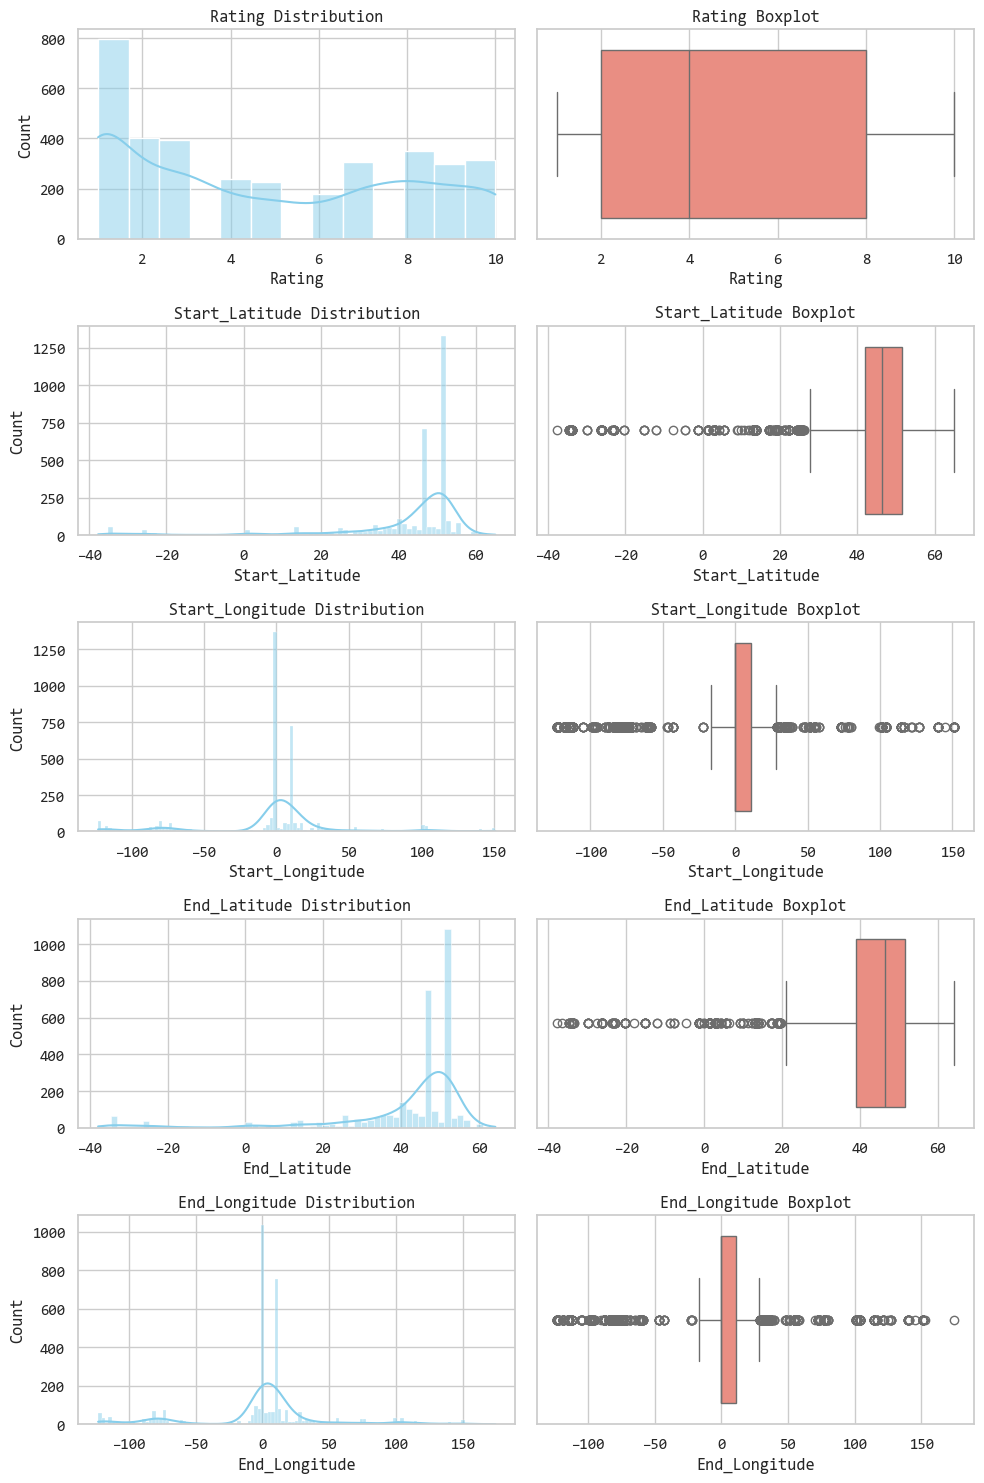

None

<Axes: >

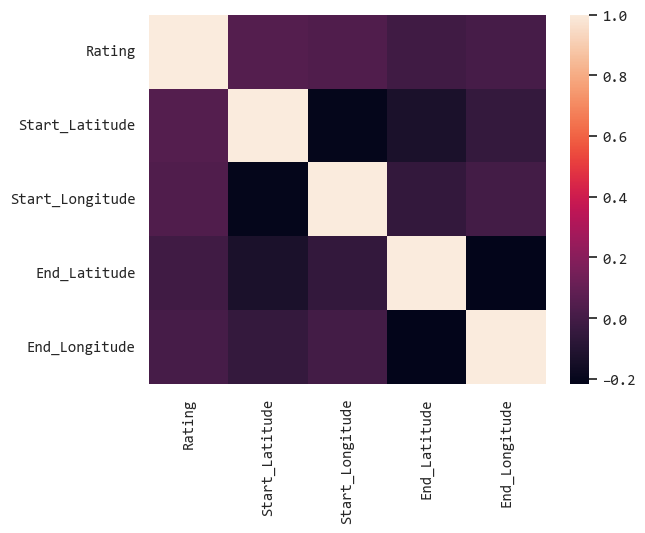

In [7]:
explore_numeric_cols(reviews_df)

In [8]:
explore_object_cols(reviews_df)

Passanger_Name  Flying_Date                   Route      Verified  \
count            3500          955                    2807          3501   
unique           2759          100                    1495             2   
top       David Ellis  August 2015  London to Johannesburg  Not Verified   
freq               43           25                      18          2434   

                           Review_title  \
count                              3501   
unique                             2567   
top     British Airways customer review   
freq                                875   

                                           Review_content  Traveller_Type  \
count                                                3501            3501   
unique                                               3501               6   
top     The airline lost my luggage and was absolutely...  Couple Leisure   
freq                                                    1             947   

                Class   Start_Location     End_Location Layover_Route  \
count            3501             2807             2807           484   
unique              5              329              380            48   
top     Economy Class  London Heathrow  London Heathrow        London   
freq             1823              582              437           202   

                                            Start_Address  \
count                                                3441   
unique                                                284   
top     Nanno, Ville d'Anaunia, Comunità della Val di ...   
freq                                                  694   

                                              End_Address  
count                                                3402  
unique                                                320  
top     Nanno, Ville d'Anaunia, Comunità della Val di ...  
freq                                                  694

================= Passanger_Name =================
David Ellis                              43
Clive Drake                              32
E Smyth                                  29
R Vines                                  13
Mike Palmer                              12
Craig Cutts                              12
Richard Hodges                           11
Bob Motto                                11
Christopher Neep                         11
John Rolfe                               10

================== Flying_Date ===================
August 2015                              25
March 2023                               23
September 2015                           23
April 2017                               21
December 2016                            21
June 2017                                20
March 2018                               19
January 2017                             19
September 2017                           19
June 2022                                19

================

- Location columns have more unique values than address columns, which is highly abnormal.
- `Traveller_Type` has a notable amount of instances where it is set to "Unknkown", we might regard it as null.
- `Traveller_Type` has outlier value "Various" and `Class` has outlier value "Unknown".
- `Start_Address` and `End_Address` have the same mode address with the same frequency which is a bit suspicious.

#### Reviews Table Data Cleaning

Passanger_Name        1
Flying_Date        2546
Route               694
Rating                0
Verified              0
Review_title          0
Review_content        0
Traveller_Type      688
Class                 0
Start_Location      694
End_Location        694
Layover_Route      3017
Start_Latitude       60
Start_Longitude      60
Start_Address        60
End_Latitude         99
End_Longitude        99
End_Address          99
dtype: int64

<Axes: >

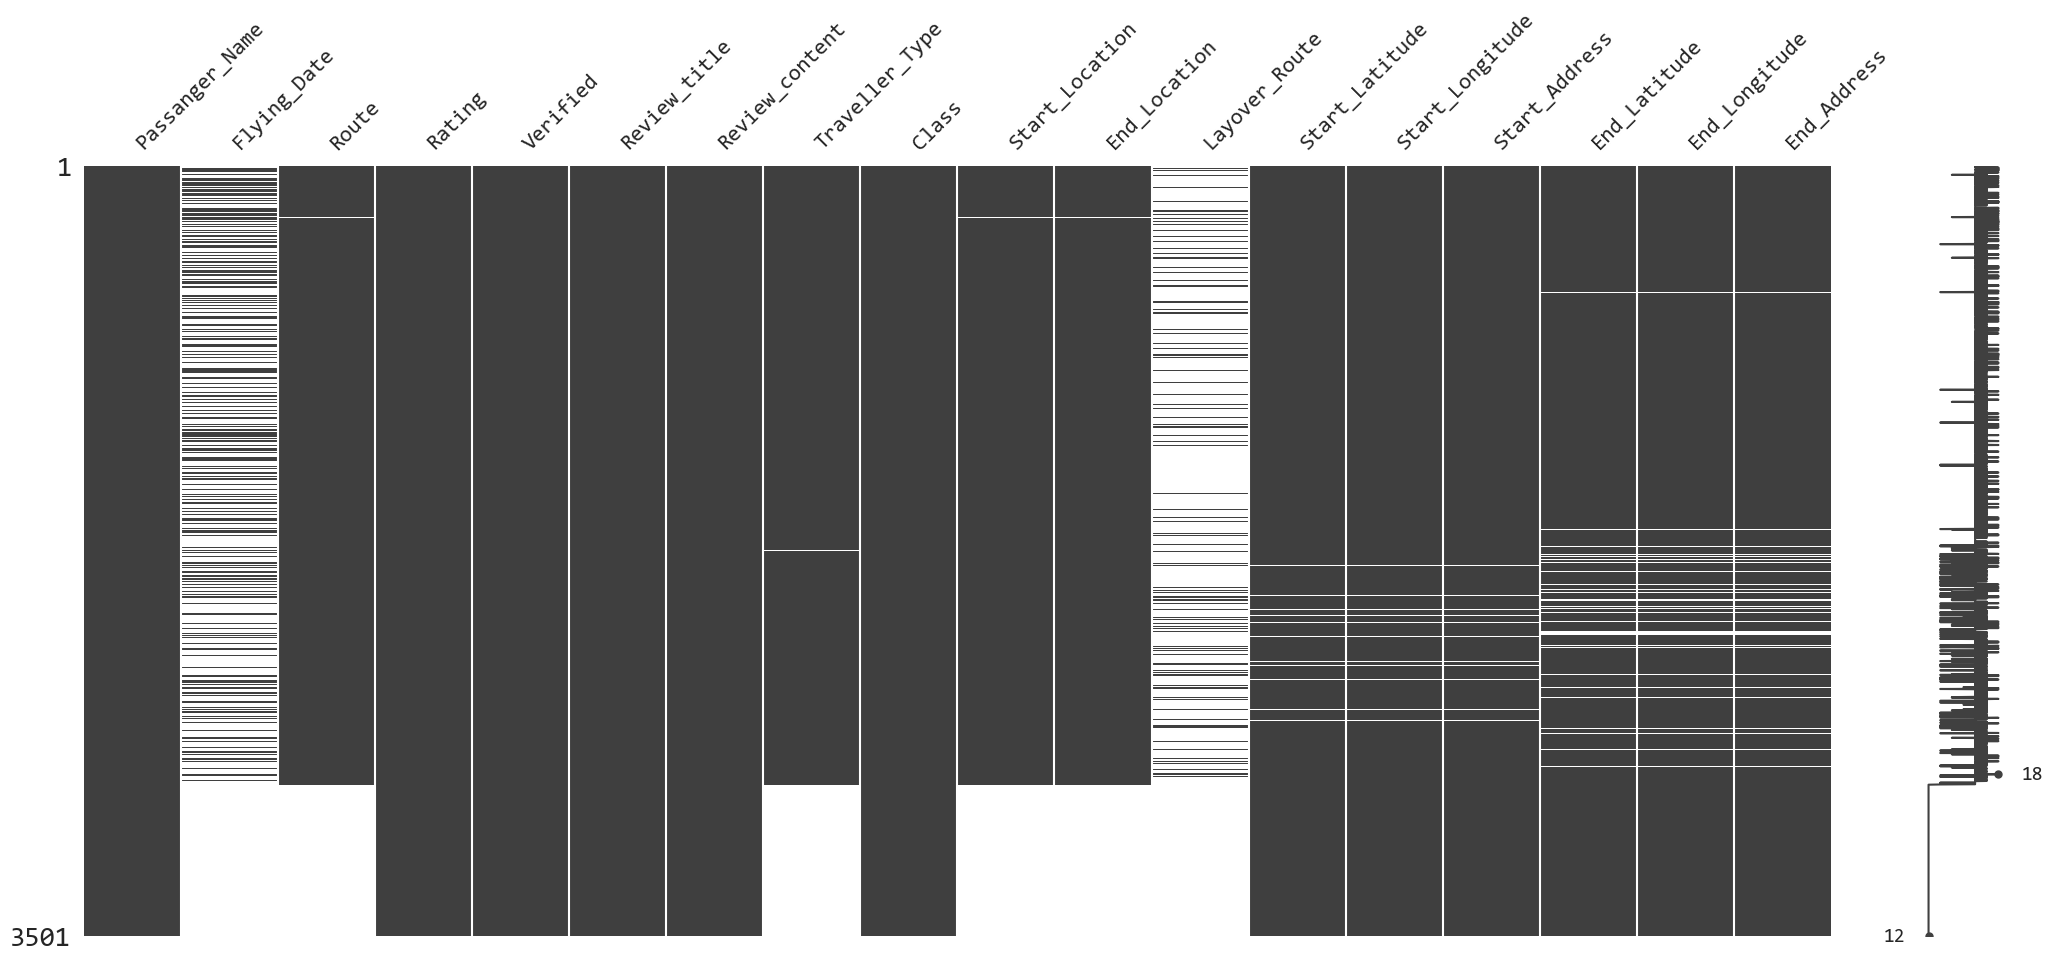

In [9]:
reviews_df.loc[reviews_df['Traveller_Type'] == 'Unknown', 'Traveller_Type'] = None

explore_na(reviews_df)

- `Flying_Date` and `Layover_Route` have a majority of null values.
- At a certain point, some specific columns start having null values regularly and systematically.
- Latiture, longitude and address can possibly be inferred from location.
- `Route` shares a gap with `Start_Location` and `End_Location`, can be filled if location can be derived from address.

In [10]:
reviews_df.drop(columns=['Flying_Date'], inplace=True)
reviews_df = reviews_df[(reviews_df['Traveller_Type'] != 'Various') & (reviews_df['Class'] != 'Unknown')]

- As the MSNO matrix shows, `Flying_Date` isn't redeemable as the significant majority of its values are null. It was dropped.
- Outlier values for `Traveller_Type` and `Various` were dropped due to their too insignificant counts.

In [11]:
reviews_df['Layover_Route'] = reviews_df['Layover_Route'].fillna('direct')

- `Layover_Route`, on the other hand, makes sense to have null as the majority of its values so it was simply filled with "direct", meaning no transits.

In [12]:
sus_addr = reviews_df['Start_Address'].mode()[0]

sus_rows = reviews_df[reviews_df['Start_Address'] == sus_addr]
print(f'Number Of Suspicious Rows: {len(sus_rows)}')

idle_flights = reviews_df[reviews_df['Start_Address'] == reviews_df['End_Address']]
print(f'Number Of Idle Flights: {len(sus_rows)}')

sus_idle_flights = pd.merge(sus_rows, idle_flights, how='inner')
print(f'Number Of Suspicious Idle Flights: {len(sus_idle_flights)}')

reviews_df = reviews_df[reviews_df['Start_Address'] != sus_addr]


Number Of Suspicious Rows: 693
Number Of Idle Flights: 693
Number Of Suspicious Idle Flights: 693


- It was decided to drop the rows that contain the anomalous address as it is illogical to have the same origin and destination for a flight.

In [13]:
max_loc_addr = reviews_df.groupby('Start_Location')['Start_Address'].nunique().max()
print(f'Maximum Number Of Unique Addresses Assigned To A Unique Location: {max_loc_addr}')

max_addr_loc = reviews_df.groupby('Start_Address')['Start_Location'].nunique().max()
print(f'Maximum Number Of Unique Locations Assigned To A Unique Address: {max_addr_loc}')

addr_loc = reviews_df.groupby('Start_Address')['Start_Location'].agg(lambda x: list(set(x))).reset_index().assign(count=lambda x: x.Start_Location.str.len()).sort_values('count', ascending=False)
display(addr_loc.head(10))

loc_diff = set(reviews_df['Start_Location']).symmetric_difference(set(reviews_df['End_Location']))
print(f'Number Of Locations That Are Only Either Start Or End: {len(loc_diff)}')

start_loc_map = (reviews_df.groupby('Start_Address')['Start_Location'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None))
reviews_df['Start_Location'] = reviews_df['Start_Address'].map(start_loc_map)

end_loc_map = (reviews_df.groupby('End_Address')['End_Location'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None))
reviews_df['End_Location'] = reviews_df['End_Address'].map(end_loc_map)

Maximum Number Of Unique Addresses Assigned To A Unique Location: 1
Maximum Number Of Unique Locations Assigned To A Unique Address: 3


Start_Address  \
192  San Jose, Santa Clara County, California, Unit...   
252                                        الدوحة, قطر   
129  London Gatwick Airport, Perimeter Road East, L...   
62   Dallas/Fort Worth International Airport, 2400,...   
85   George Bush Intercontinental Airport - Houston...   
109  John F. Kennedy International Airport, JFK Acc...   
28   Belfast, County Antrim, Northern Ireland / Tua...   
122  Leeds Bradford Airport, Scotland Lane, Moor Si...   
100  Hewanorra International Airport, New Dock Road...   
260  عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...   

                                        Start_Location  count  
192            [San Jose, San Jose (CA), San Jose, CA]      3  
252                                       [doha, Doha]      2  
129                       [London Gatwick, London LGW]      2  
62                [Dallas Fort-Worth, Dallas Ft Worth]      2  
85   [iAH, Houston, TX - George Bush Intercontinent...      2  
109    [New York JFK, New York - John F. Kennedy (NY)]      2  
28                             [Belfast, Belfast City]      2  
122                   [Leeds Bradford, Leeds/Bradford]      2  
100                         [UVF, St. Lucia Hewanorra]      2  
260                              [Amman, Amman Jordan]      2

Number Of Locations That Are Only Either Start Or End: 187


- Upon inspection of the abnormal difference in the number of unique values between locations and addresses, it was discovered that their relationship is many:1 instead of 1:many.
- Further investigation uncovered that this inaccuracy is attributed to the fact that a single location can appear in the form of multiple variants throught the table.
- This has been corrected by assigning all addresses that belong to any variants of a particular location to the most repeated variant of that location.
- Can not only depend on either start or end, must depend on both as their set difference isn't empty. So, a separate map was created for both start and end.
- - -
- The selected variant is rather a local mode than a global mode.
- The only way to implement a solution with the much more accruate global mode will be to link all variants togther to the most repeated variant, which requires a complex solution that we reckon exceeds the scope of the current task.
- **MAYBE** Investigate if this complex soultion can be dropped in favor of depending on another column like `Route` for example, if possible.

In [14]:
na_start_addr = reviews_df[reviews_df['Start_Address'].isna()]
print('Null Start Addresses:')
display(na_start_addr.head(5))

na_end_addr = reviews_df[reviews_df['End_Address'].isna()]
print('Null End Addresses:')
display(na_end_addr.head(5))

infer_start_addr = na_start_addr['Start_Location'].isin(reviews_df[~reviews_df['Start_Address'].isna()]['Start_Location'])
print(f'Number Of Inferable Start Addresses From Start Locations: {infer_start_addr.sum()}')

infer_end_addr = na_end_addr['End_Location'].isin(reviews_df[~reviews_df['End_Address'].isna()]['End_Location'])
print(f'Number Of Inferable End Addresses From End Locations: {infer_end_addr.sum()}')

reviews_df.dropna(subset=['Start_Address', 'End_Address'], inplace=True)

Null Start Addresses:


Passanger_Name                         Route  Rating       Verified  \
1019      Roger Stone                    HKG to LHR       8  Trip Verified   
1168    Carlos Arenas  Edimbourgh to London Gatwick       3  Trip Verified   
1360       John Barry  Zakinthos to London Heathrow       8   Not Verified   
1737  Vincent Borlaug            IAD to BCN via LHR      10   Not Verified   
1749        J Hicklin            SFO to JNB via LHR       6   Not Verified   

                       Review_title  \
1019        an enjoyable experience   
1168     I end up with mix feelings   
1360         very good flight again   
1737          still my first choice   
1749  as different as night and day   

                                         Review_content  Traveller_Type  \
1019  I thought it time BA deserved some compliments...        Business   
1168  I have traveled several times with British Air...  Couple Leisure   
1360  Verified Review   Zakinthos to London Heathrow...  Family Leisure   
1737  Verified Review   Washington to Barcelona retu...    Solo Leisure   
1749  Verified Review   San Francisco to Johannesbur...    Solo Leisure   

                Class Start_Location  \
1019  Premium Economy            NaN   
1168    Economy Class            NaN   
1360   Business Class            NaN   
1737  Premium Economy            NaN   
1749   Business Class            NaN   

                                       End_Location      Layover_Route  \
1019                                London Heathrow             direct   
1168                                 London Gatwick             direct   
1360                                London Heathrow             direct   
1737                                      Barcelona  London - Heathrow   
1749  Johannesburg - OR Tambo International Airport  London - Heathrow   

      Start_Latitude  Start_Longitude Start_Address  End_Latitude  \
1019             NaN              NaN           NaN     51.467739   
1168             NaN              NaN           NaN     51.154108   
1360             NaN              NaN           NaN     51.467739   
1737             NaN              NaN           NaN     41.382894   
1749             NaN              NaN           NaN    -26.136013   

      End_Longitude                                        End_Address  
1019      -0.458780  London Heathrow Airport, Northern Perimeter Ro...  
1168      -0.182312  London Gatwick Airport, Perimeter Road East, L...  
1360      -0.458780  London Heathrow Airport, Northern Perimeter Ro...  
1737       2.177432  Barcelona, Barcelonès, Barcelona, Catalunya, 0...  
1749      28.244977  O.R. Tambo International Airport, Elgin Street...

Null End Addresses:


Passanger_Name                         Route  Rating       Verified  \
357          J Prescott     Dubai to London Heaathrow       6  Trip Verified   
575           A Maharif  doha to londonDoha to London       9  Trip Verified   
1074  Wolfgang Bernhart      Frankfurt to London Cuty       1  Trip Verified   
1363         John Barry  London Heathrow to Zakinthos       9   Not Verified   
1652          Ron Baker                    LHR to GVA       2   Not Verified   

                                  Review_title  \
357               just used the new Club World   
575                   Surprisingly good flight   
1074                    There is not a hotline   
1363                   kind and chatty with us   
1652  not what one expects from Business Class   

                                         Review_content  Traveller_Type  \
357   We've just used the new Club World for the fir...  Couple Leisure   
575   Doha to London. Surprisingly good flight, onti...  Family Leisure   
1074  When I checked in the evening before for the 7...        Business   
1363  Verified Review   London Heathrow to Zakinthos...  Family Leisure   
1652  Verified Review   Flew from London Heathrow to...  Couple Leisure   

               Class   Start_Location End_Location Layover_Route  \
357   Business Class            Dubai          NaN        direct   
575    Economy Class             Doha          NaN        direct   
1074   Economy Class        Frankfurt          NaN        direct   
1363  Business Class  London Heathrow          NaN        direct   
1652  Business Class  London Heathrow          NaN        direct   

      Start_Latitude  Start_Longitude  \
357        25.265347        55.292491   
575        25.285633        51.526416   
1074       50.110644         8.682092   
1363       51.467739        -0.458780   
1652       51.467739        -0.458780   

                                          Start_Address  End_Latitude  \
357                       دبي, الإمارات العربية المتحدة           NaN   
575                                         الدوحة, قطر           NaN   
1074             Frankfurt am Main, Hessen, Deutschland           NaN   
1363  London Heathrow Airport, The Beacon Roundabout...           NaN   
1652  London Heathrow Airport, The Beacon Roundabout...           NaN   

      End_Longitude End_Address  
357             NaN         NaN  
575             NaN         NaN  
1074            NaN         NaN  
1363            NaN         NaN  
1652            NaN         NaN

Number Of Inferable Start Addresses From Start Locations: 0
Number Of Inferable End Addresses From End Locations: 0


- We have three ways to deal with a missing addresses:
  - Derive it from location.
  - Set it to location.
  - Drop it.
- - -
- We aim to exploit the assumed to exist 1:many relationship between `Start_Location` and `Start_Address` because logically, the latter should imply the former.
- This was a failed attempt to infer `Start_Address` from `Start_Location` as null addresses' locations do not have other non-null addresses.
- - -
- The tables demonstrate that the lack of addresses is sometimes attributed to a typo in specifying the locations.
- **UNSURE** It would be unwise to impute the latitude and longitudes according to a global statistic and not something local to for ex. location, which unfortunately lacks non-null replacements for null addresses / latitiudes / logitudes.
- Very little can be done to resolve that without the aid of something like an LLM, but we reckon that exceeds the scope of this task.
- - -
- It was decided to drop the missing addresses due to their insignificant count, in order to ensure data availability across all columns. Filling it with the locations' values felt like it was going to undermine the already existing addresses.
- **UNSURE** A small part of the data size was sacrificed for overall data completeness.

In [15]:
first_word_mode = reviews_df['Review_content'].str.split().str[0].mode()[0]
print(f'Most Repeated First Word In Reviews: {first_word_mode}')

reviews_df.loc[reviews_df['Review_content'].str.startswith('Verified Review   '), 'Verified'] = 'Trip Verified'
reviews_df.loc[reviews_df['Review_content'].str.match(r'^❎(?: Unverified)?   '), 'Verified'] = 'Not Verified'

reviews_df['Review_content'] = reviews_df['Review_content'].str.replace(r'^(?:Verified Review|❎(?: Unverified)?)   ', '', regex=True)

Most Repeated First Word In Reviews: Verified


- The mode first word in `Review_content` indicates possible column interference and upon further exploration of the data, it was confirmed that the column indeed somestimes does include data rather meant for the `Verified` column.

Passanger_Name     0
Route              0
Rating             0
Verified           0
Review_title       0
Review_content     0
Traveller_Type     2
Class              0
Start_Location     0
End_Location       0
Layover_Route      0
Start_Latitude     0
Start_Longitude    0
Start_Address      0
End_Latitude       0
End_Longitude      0
End_Address        0
dtype: int64

<Axes: >

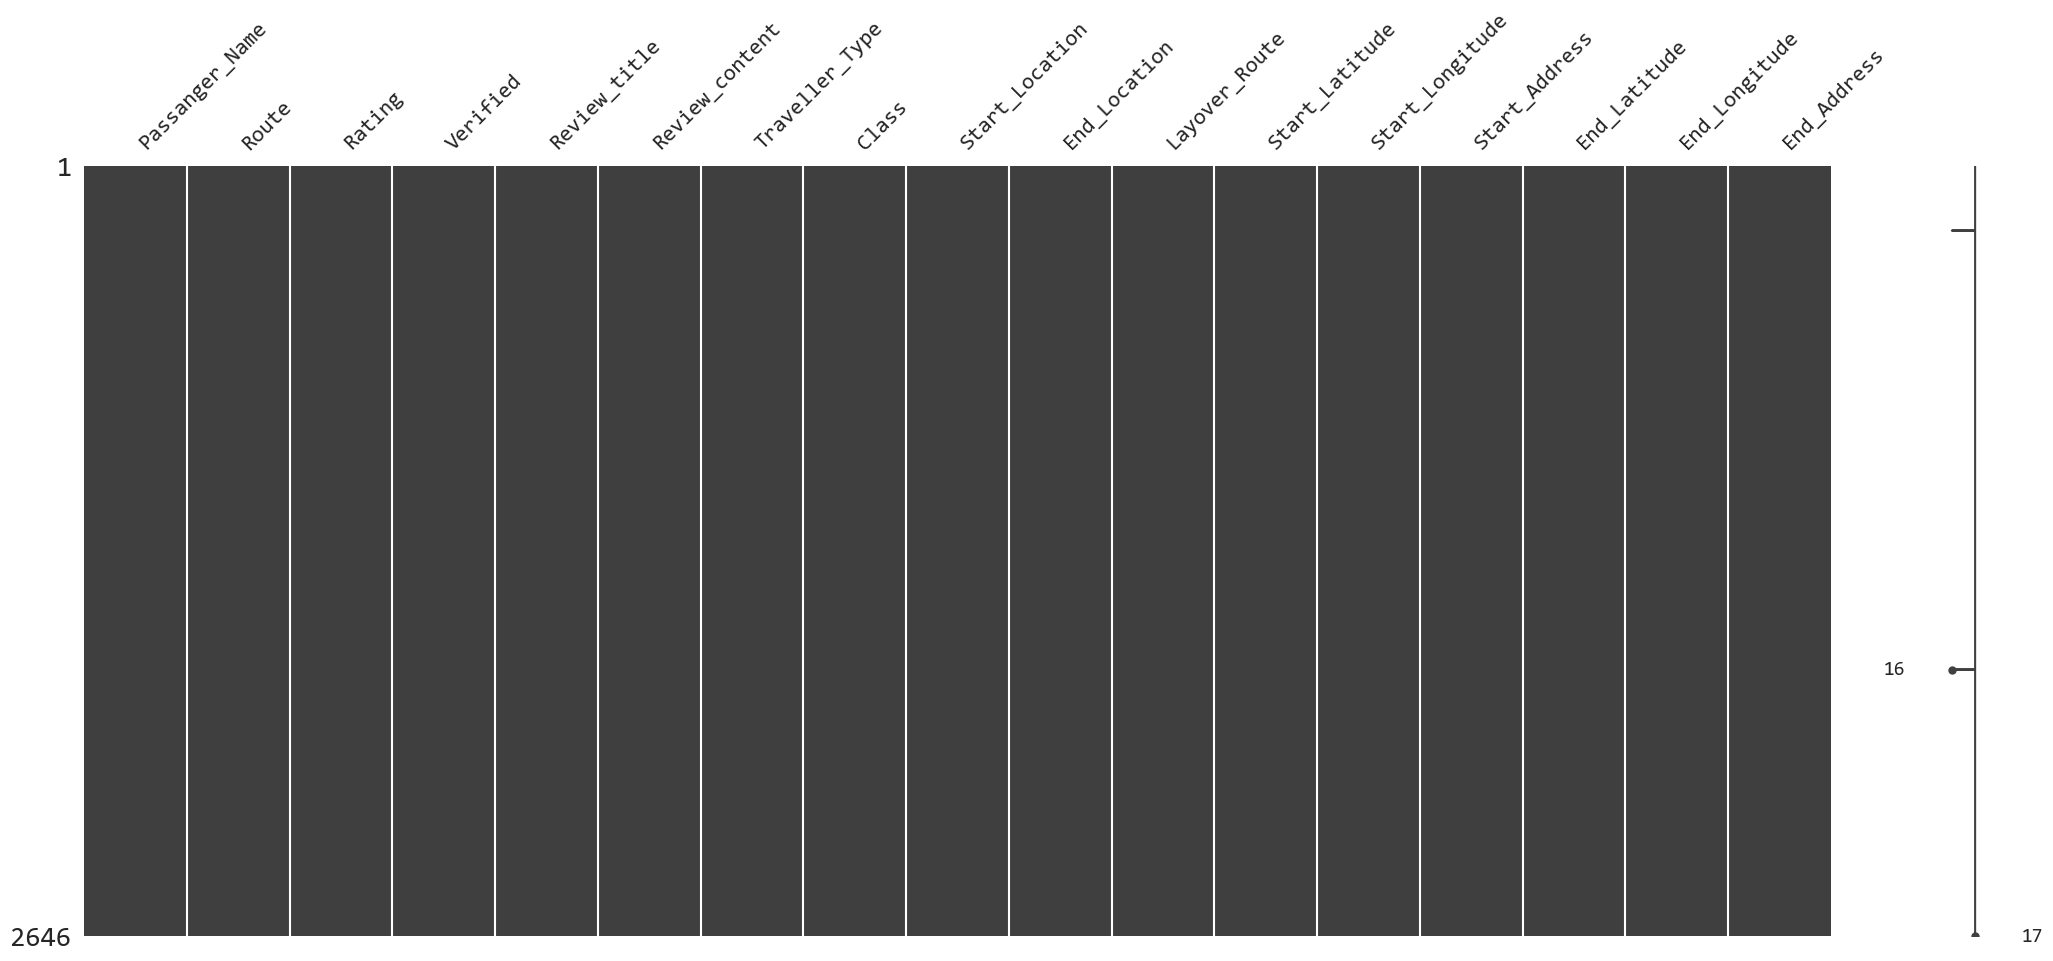

In [16]:
explore_na(reviews_df)

- The row lacking the `Passanger_Name` field is no longer present.
- Only two instaces of a null `Traveller_Type` remain.
- The gap shared between `Route`, `Start_Location` and `End_Location` is no longer present. We no longer need to attempt to derive location from address.
- These effects were observed after the removal operations concerning the anomalous address repeating plus the missing addresses.

In [17]:
reviews_df.dropna(subset=['Traveller_Type'], inplace=True)

- It was decided to drop the missing `Traveller_Type` instances due to their very insignificant count, in order to ensure data availability across all columns.

In [18]:
reviews_df.rename(columns={
    'Passanger_Name': 'passenger_name',
    'Route': 'route',
    'Rating': 'rating',
    'Verified': 'verified',
    'Review_title': 'review_title',
    'Review_content': 'review_content',
    'Traveller_Type': 'traveller_type',
    'Class': 'class',
    'Start_Location': 'start_location',
    'End_Location': 'end_location',
    'Layover_Route': 'layover_route',
    'Start_Latitude': 'start_latitude',
    'Start_Longitude': 'start_longitude',
    'Start_Address': 'start_address',
    'End_Latitude': 'end_latitude',
    'End_Longitude': 'end_longitude',
    'End_Address': 'end_address'
}, inplace=True)

- Column names were changed to use a more consistent and conventional case.

#### Reviews Table Feature Engineering

In [19]:
sentiment_analyzer = SentimentIntensityAnalyzer()
reviews_df['sentiment'] = reviews_df['review_content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

display(reviews_df['sentiment'].describe())

count    2644.000000
mean        0.115838
std         0.782095
min        -0.997500
25%        -0.764700
50%         0.332600
75%         0.914325
max         0.999200
Name: sentiment, dtype: float64

In [20]:
reviews_df.to_csv('processed_dataset/airline_reviews.csv', index=False)

### Comments Table Data Processing

#### Comments Table Data Exploration

In [21]:
comments_df = pd.read_csv('raw_dataset/Customer_comment.csv')

In [22]:
clean_text(reviews_df)
dedupe(comments_df)

Number Of Dropped Duplicates: 0


In [23]:
display(comments_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                9424 non-null   int64 
 1   flight_number             9424 non-null   int64 
 2   origin_station_code       9424 non-null   object
 3   destination_station_code  9424 non-null   object
 4   scheduled_departure_date  9424 non-null   object
 5   arrival_delay_group       9424 non-null   object
 6   departure_delay_group     9424 non-null   object
 7   entity                    9424 non-null   object
 8   verbatim_text             9424 non-null   object
 9   seat_factor_band          9424 non-null   object
 10  ques_verbatim_text        9424 non-null   object
 11  loyalty_program_level     6920 non-null   object
 12  fleet_type_description    9424 non-null   object
 13  fleet_usage               9424 non-null   object
 14  response_group          

None

- The first column lacks a name.
- The majority of the columns are of type object, all except one.

Unnamed: 0  flight_number
count  9424.000000    9424.000000
mean   4711.500000    1741.573430
std    2720.618802    1550.550037
min       0.000000       2.000000
25%    2355.750000     614.000000
50%    4711.500000    1286.000000
75%    7067.250000    2261.000000
max    9423.000000    6375.000000

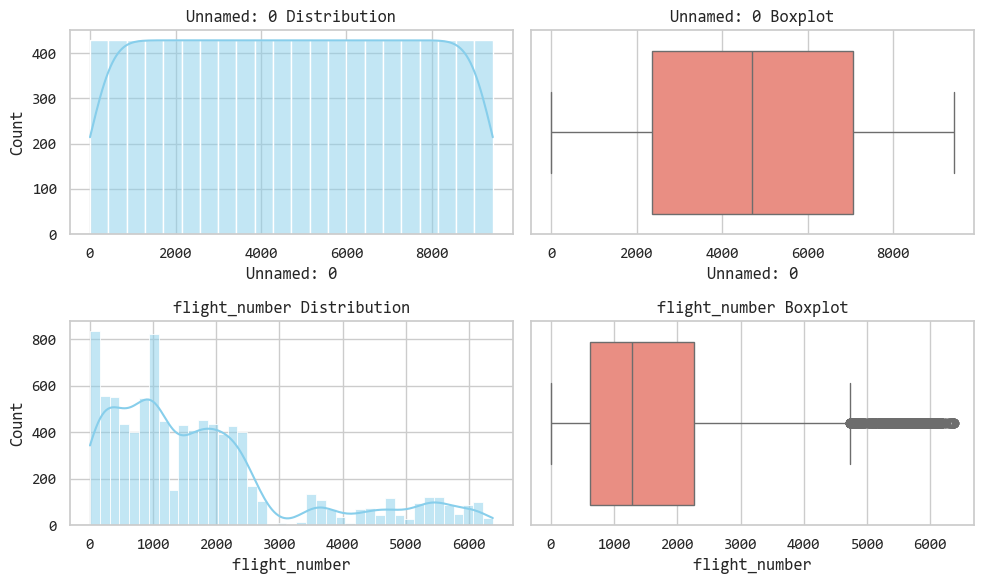

None

<Axes: >

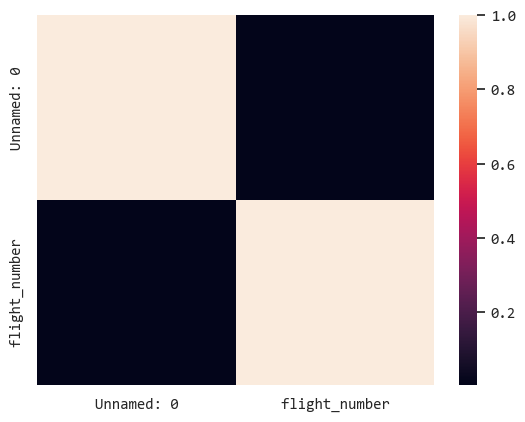

In [24]:
explore_numeric_cols(comments_df)

In [25]:
explore_object_cols(comments_df)

origin_station_code destination_station_code scheduled_departure_date  \
count                 9424                     9424                     9424   
unique                 195                      192                       30   
top                    IAX                      IAX               2022-09-10   
freq                  1149                     1427                      399   

       arrival_delay_group departure_delay_group    entity verbatim_text  \
count                 9424                  9424      9424          9424   
unique                   2                     2         4          8013   
top         Early & Ontime        Early & Ontime  Domestic           No.   
freq                  6811                  6241      6593           774   

       seat_factor_band                                 ques_verbatim_text  \
count              9424                                               9424   
unique                4                                                  1   
top                 90+  Is there anything else you'd like to share abo...   
freq               6302                                               9424   

       loyalty_program_level fleet_type_description fleet_usage  \
count                   6920                   9424        9424   
unique                     7                     22           2   
top                non-elite               B737-900    Mainline   
freq                    4128                   1451        7985   

       response_group sentiments transformed_text  
count            9424       9424             8405  
unique              3          2             7609  
top            member    Neutral             none  
freq             6905       9307               97

============== origin_station_code ===============
IAX                                      1149
EWX                                      1009
DEX                                      942
ORX                                      893
SFX                                      720
LAX                                      407
LHX                                      247
HNX                                      150
SAX                                      146
BOX                                      146

============ destination_station_code ============
IAX                                      1427
EWX                                      1210
ORX                                      947
DEX                                      872
SFX                                      768
LAX                                      443
LHX                                      179
HNX                                      148
MCX                                      137
SAX                                   

- `ques_verbatim_text` has one single value.
- `loyalty_program_level` and `response_group` have outlier value "NBK".

Unnamed: 0                     0
flight_number                  0
origin_station_code            0
destination_station_code       0
scheduled_departure_date       0
arrival_delay_group            0
departure_delay_group          0
entity                         0
verbatim_text                  0
seat_factor_band               0
ques_verbatim_text             0
loyalty_program_level       2504
fleet_type_description         0
fleet_usage                    0
response_group                 0
sentiments                     0
transformed_text            1019
dtype: int64

<Axes: >

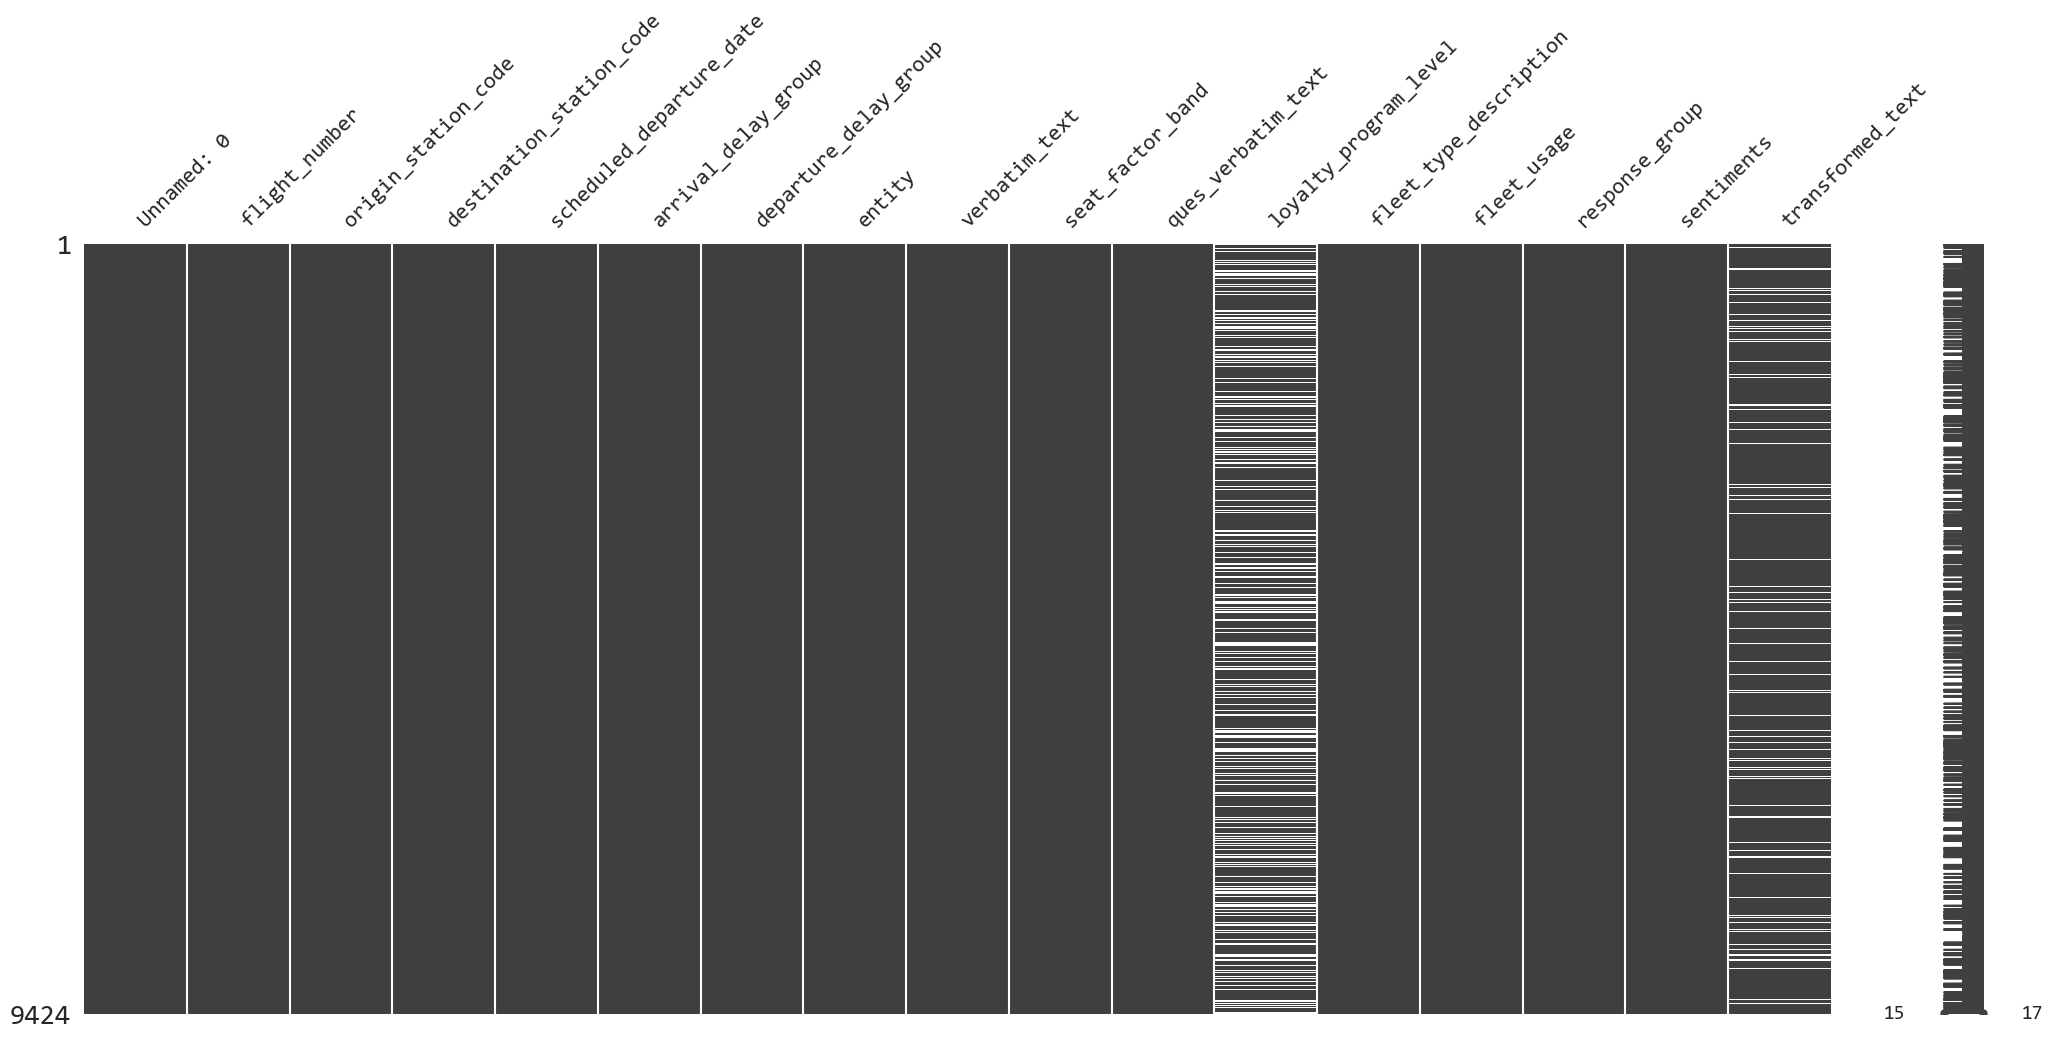

In [26]:
explore_na(comments_df)

- `loyalty_program_level` has a notable minority of missing values, should be inferrable from `response_group`.
- `transformed_text` inicates the result of an operation on `verbatim_text`, should be inferrable from it.

#### Comments Table Data Cleaning

In [27]:
comments_df.drop(columns=['Unnamed: 0', 'ques_verbatim_text'], inplace=True)
comments_df = comments_df[comments_df['loyalty_program_level'] != 'NBK']

- The unnamed column was dropped for being just a unique identifier, which is redundant to our needs.
- `ques_verbatim_text` was dropped for having the same value across all rows.
- The outler value between `loyalty_program_level` and `response_group` was dropped.

In [28]:
resp_vs_loyalty = pd.crosstab(comments_df['response_group'], comments_df['loyalty_program_level'], dropna=False)
display(resp_vs_loyalty)

comments_df['loyalty_program_level'] = comments_df['loyalty_program_level'].fillna('non-loyal')

loyalty_program_level  global services  non-elite  premier 1k  premier gold  \
response_group                                                                
member                             140       4115         722           603   
non-member                           0         13           0             1   

loyalty_program_level  premier platinum  premier silver   NaN  
response_group                                                 
member                              451             874     0  
non-member                            0               0  2504

- The assumed correlation between `response_group` and `loyalty_program_level` was investigated and a strongly possible relationship was found.
- Null values in `loyalty_program_level` are attributed to an actual lack of a loyalty level mostly due to lack of membership, so they were filled accordingly.

In [29]:
na_transtext = comments_df[comments_df['transformed_text'].isna()]
print("Null Transformed Texts:")
display(na_transtext[['verbatim_text']].head(5))

comments_df['transformed_text'] = comments_df['transformed_text'].fillna('')

Null Transformed Texts:


verbatim_text
11           no.
27           No.
42           no.
43           no.
44           No.

- Null values in `transformed_text` are attributed to an actual lack of a response, so they were filled to reflect that.

flight_number               0
origin_station_code         0
destination_station_code    0
scheduled_departure_date    0
arrival_delay_group         0
departure_delay_group       0
entity                      0
verbatim_text               0
seat_factor_band            0
loyalty_program_level       0
fleet_type_description      0
fleet_usage                 0
response_group              0
sentiments                  0
transformed_text            0
dtype: int64

<Axes: >

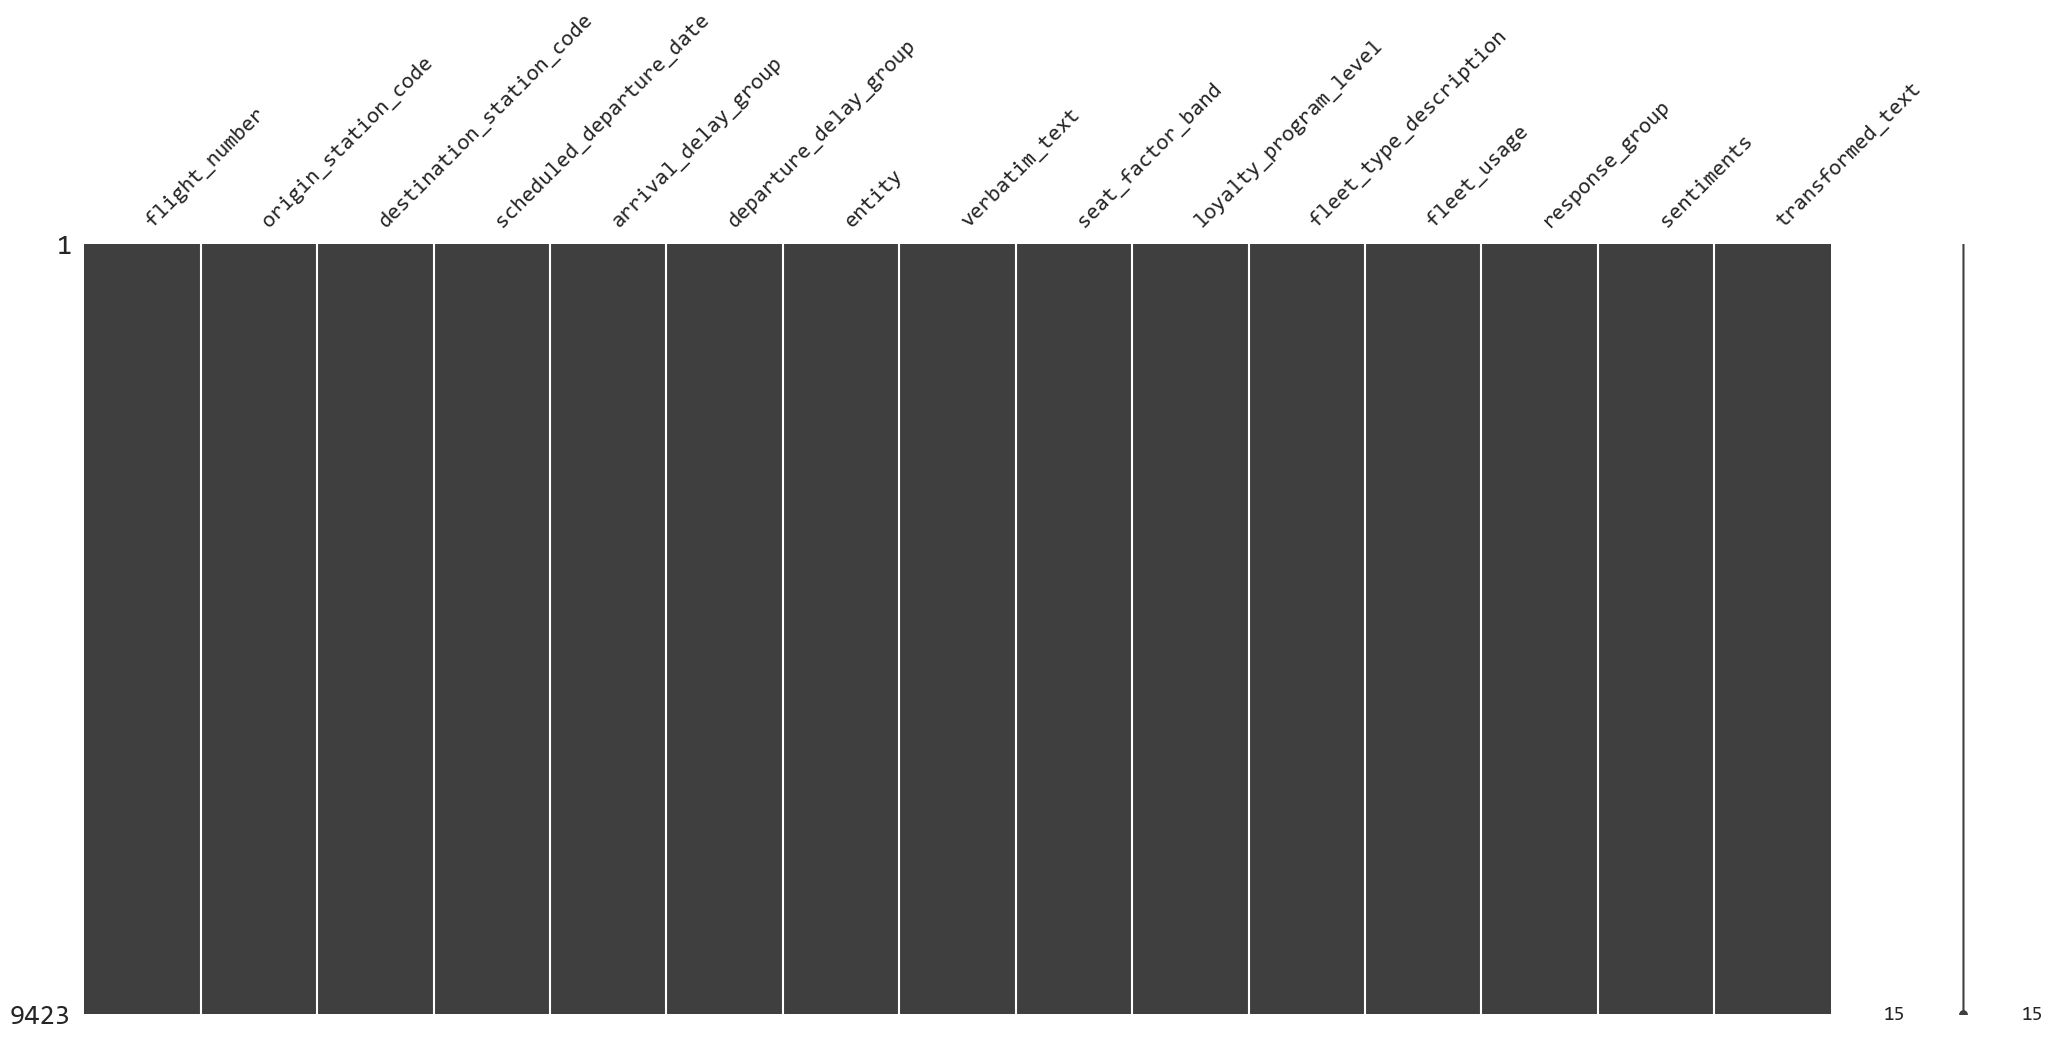

In [30]:
explore_na(comments_df)

In [31]:
comments_df.to_csv('processed_dataset/customer_comments.csv', index=False)

### Bookings Table Data Processing

#### Bookings Table Data Exploration

In [32]:
bookings_df = pd.read_csv('raw_dataset/Passanger_booking_data.csv')

In [33]:
clean_text(reviews_df)
dedupe(bookings_df)

Number Of Dropped Duplicates: 719


In [34]:
display(bookings_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 49283 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49283 non-null  int64  
 1   sales_channel          49283 non-null  object 
 2   trip_type              49283 non-null  object 
 3   purchase_lead          49283 non-null  int64  
 4   length_of_stay         49283 non-null  int64  
 5   flight_hour            49283 non-null  int64  
 6   flight_day             49283 non-null  object 
 7   route                  49283 non-null  object 
 8   booking_origin         49283 non-null  object 
 9   wants_extra_baggage    49283 non-null  int64  
 10  wants_preferred_seat   49283 non-null  int64  
 11  wants_in_flight_meals  49283 non-null  int64  
 12  flight_duration        49283 non-null  float64
 13  booking_complete       49283 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ MB


None

num_passengers  purchase_lead  length_of_stay   flight_hour  \
count    49283.000000   49283.000000    49283.000000  49283.000000   
mean         1.590204      84.723393       23.054197      9.070613   
std          1.016540      90.409389       33.831644      5.413007   
min          1.000000       0.000000        0.000000      0.000000   
25%          1.000000      21.000000        5.000000      5.000000   
50%          1.000000      51.000000       17.000000      9.000000   
75%          2.000000     115.000000       28.000000     13.000000   
max          9.000000     867.000000      778.000000     23.000000   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
count         49283.000000          49283.000000           49283.000000   
mean              0.668222              0.295639               0.426638   
std               0.470856              0.456334               0.494594   
min               0.000000              0.000000               0.000000   
25%               0.000000              0.000000               0.000000   
50%               1.000000              0.000000               0.000000   
75%               1.000000              1.000000               1.000000   
max               1.000000              1.000000               1.000000   

       flight_duration  booking_complete  
count     49283.000000      49283.000000  
mean          7.279937          0.149991  
std           1.496381          0.357066  
min           4.670000          0.000000  
25%           5.620000          0.000000  
50%           7.570000          0.000000  
75%           8.830000          0.000000  
max           9.500000          1.000000

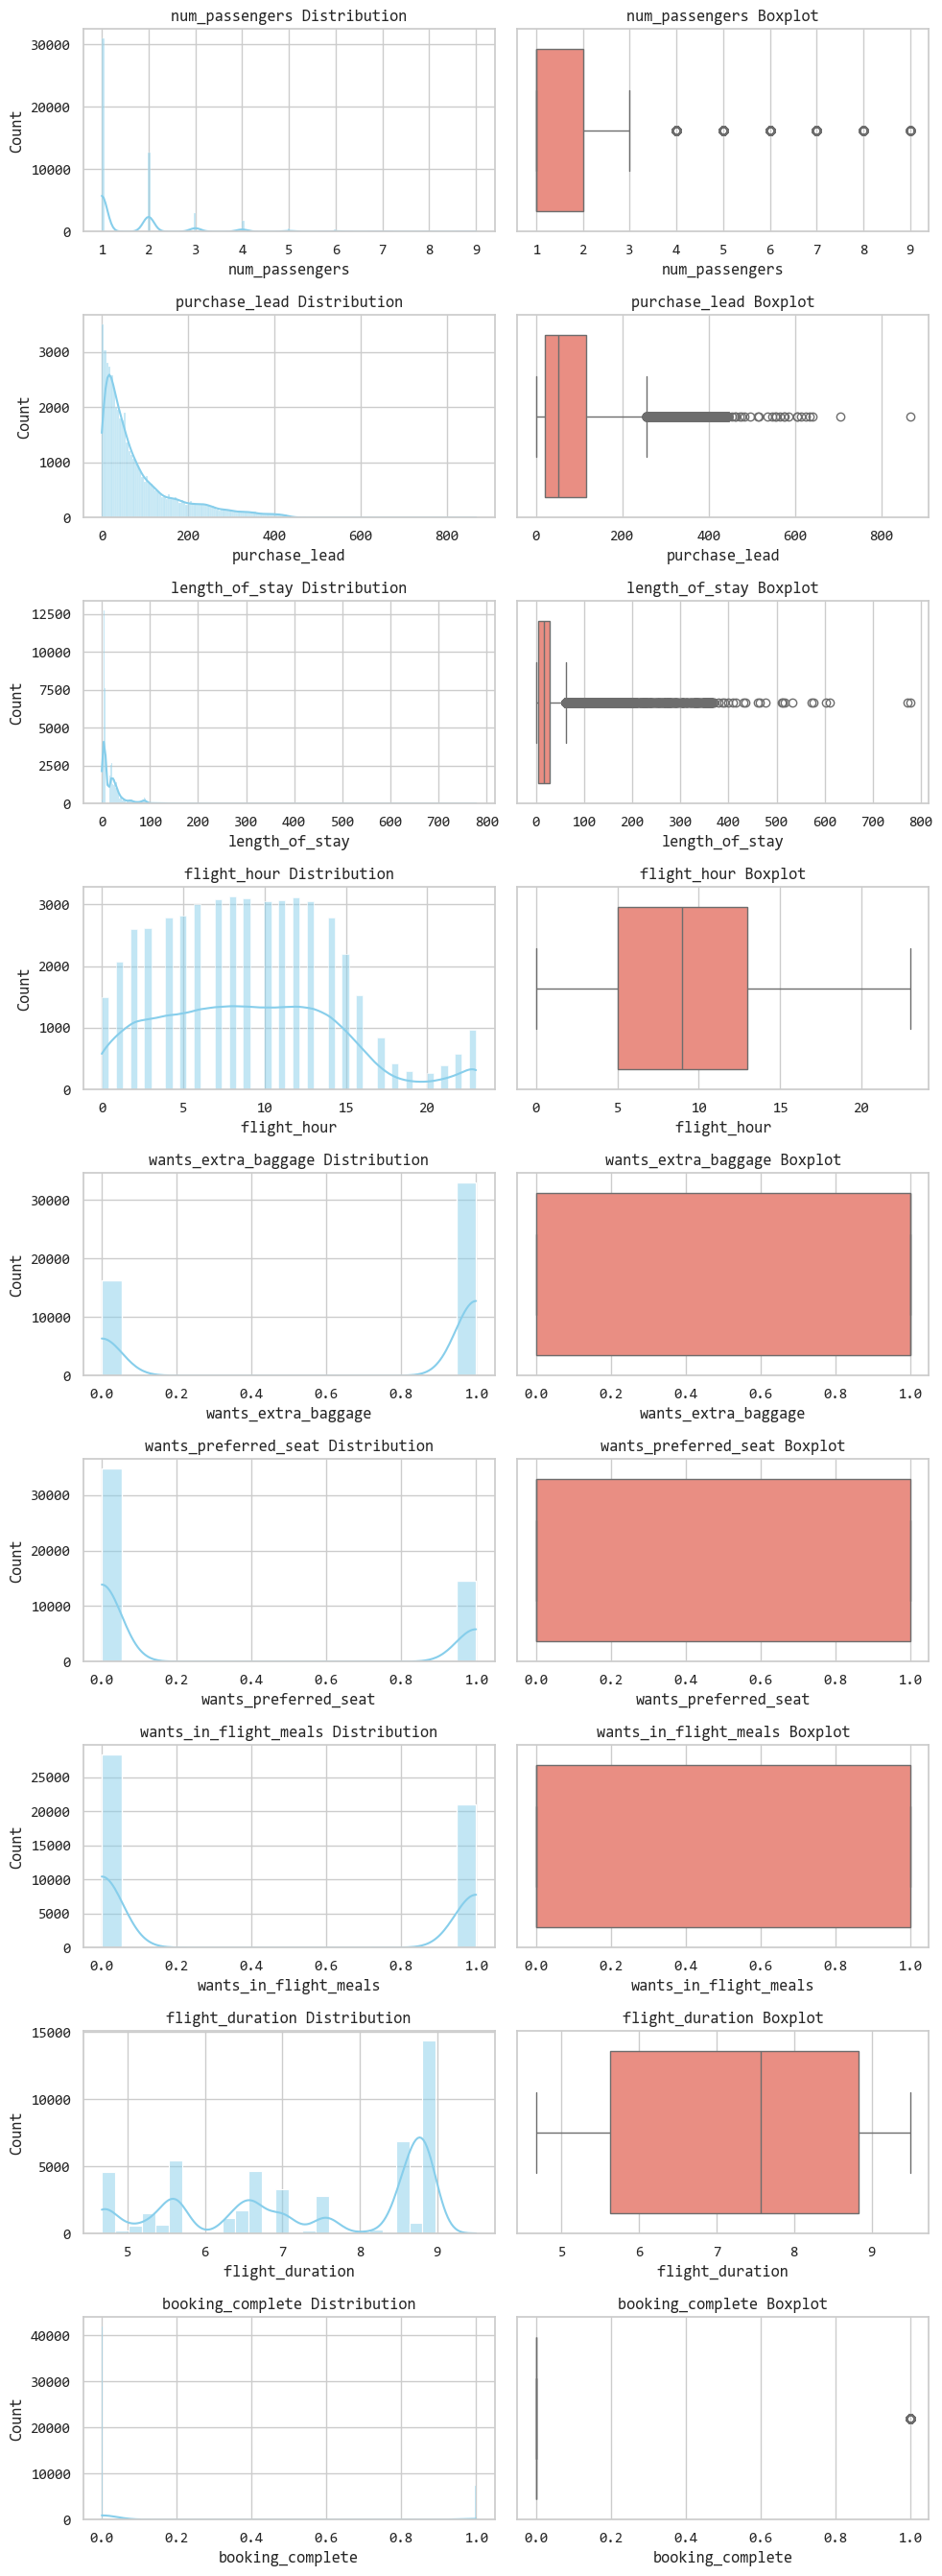

None

<Axes: >

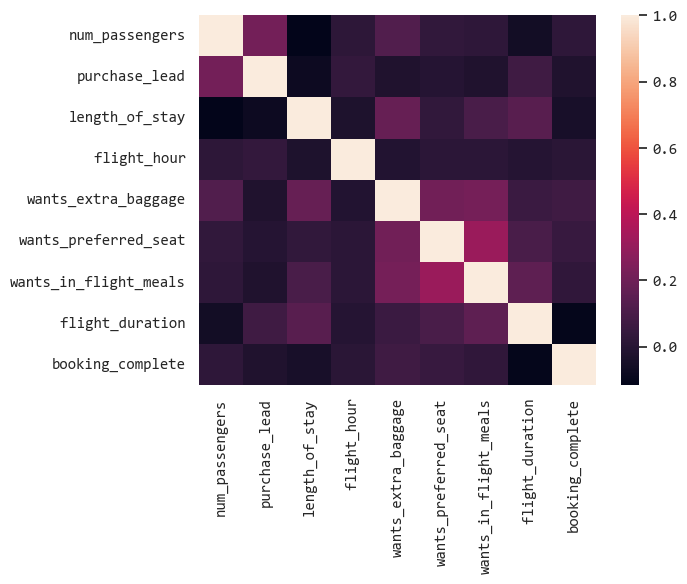

In [35]:
explore_numeric_cols(bookings_df)

In [36]:
explore_object_cols(bookings_df)

sales_channel  trip_type flight_day   route booking_origin
count          49283      49283      49283   49283          49283
unique             2          3          7     799            104
top         Internet  RoundTrip        Mon  AKLKUL      Australia
freq           43918      48780       7988    2620          17692

================= sales_channel ==================
Internet                                 43918
Mobile                                   5365

=================== trip_type ====================
RoundTrip                                48780
OneWay                                   386
CircleTrip                               117

=================== flight_day ===================
Mon                                      7988
Wed                                      7563
Tue                                      7559
Thu                                      7323
Fri                                      6685
Sun                                      6442
Sat                                      5723

===================== route ======================
AKLKUL                                   2620
PENTPE                                   912
MELSGN                                   833
ICNSIN                                   793
DMKKIX                                   729
ICNSYD         

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

<Axes: >

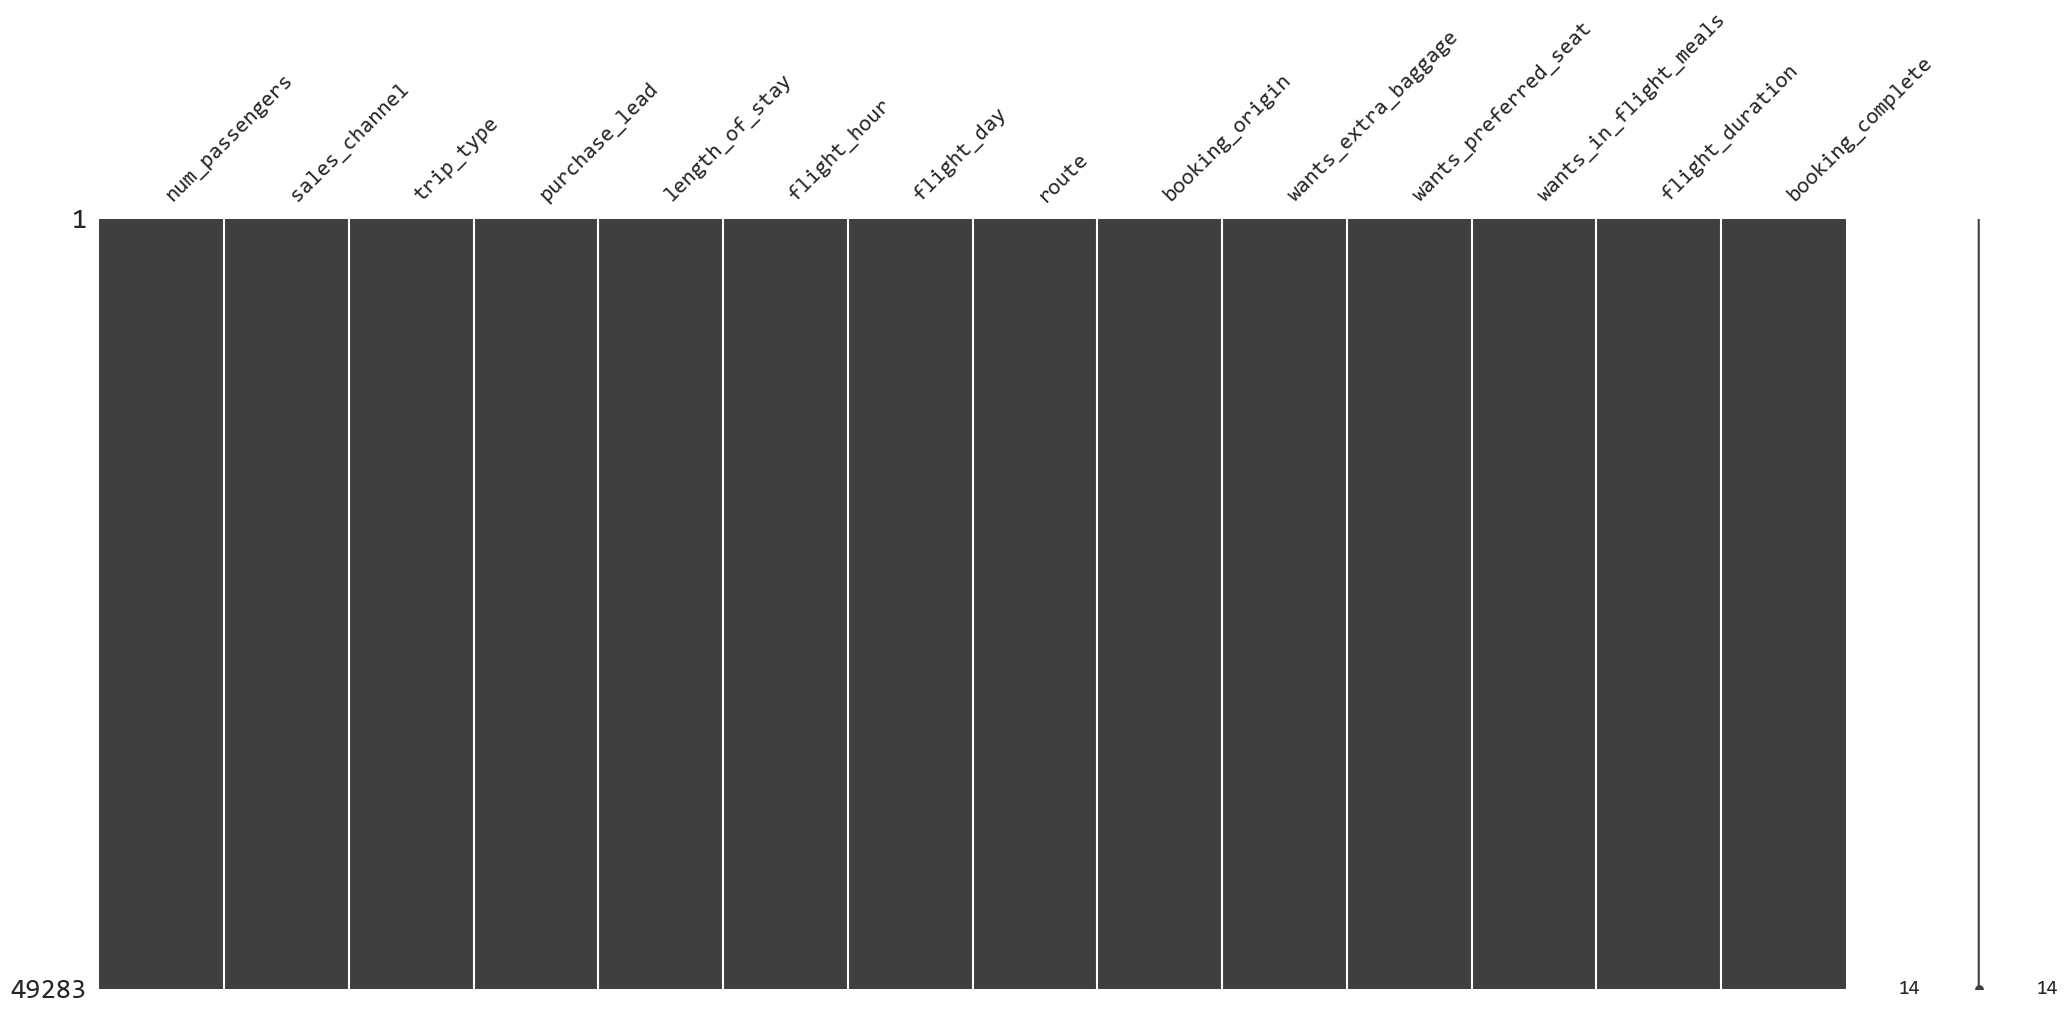

In [37]:
explore_na(bookings_df)

- Data is clean and sound, no fillings or droppings were made. Only deduplications.

In [38]:
bookings_df.to_csv('processed_dataset/passenger_bookings.csv', index=False)

### Surveys Table Data Processing

#### Surveys Table Data Exploration

In [120]:
surveys_df = pd.read_csv('raw_dataset/Survey data_Inflight Satisfaction Score.csv')

In [121]:
clean_text(surveys_df)
dedupe(surveys_df)

Number Of Dropped Duplicates: 0


In [122]:
display(surveys_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   flight_number                     47074 non-null  int64 
 1   origin_station_code               47074 non-null  object
 2   destination_station_code          47074 non-null  object
 3   record_locator                    47074 non-null  object
 4   scheduled_departure_date          47074 non-null  object
 5   question_text                     47074 non-null  object
 6   score                             47074 non-null  object
 7   satisfaction_type                 34963 non-null  object
 8   driver_sub_group1                 47074 non-null  object
 9   driver_sub_group2                 47074 non-null  object
 10  arrival_delay_minutes             47074 non-null  int64 
 11  arrival_delay_group               47074 non-null  object
 12  cabin_code_desc   

None

flight_number  arrival_delay_minutes  number_of_legs  \
count   47074.000000           47074.000000    47074.000000   
mean     1529.855207              -1.702490        1.344118   
std      1456.712299              37.868177        0.502424   
min         2.000000            -104.000000        1.000000   
25%       477.000000             -19.000000        1.000000   
50%      1050.000000              -9.000000        1.000000   
75%      2060.000000               4.000000        2.000000   
max      6376.000000             907.000000        3.000000   

       actual_flown_miles  
count        47074.000000  
mean          2477.737732  
std           1865.646538  
min             45.000000  
25%            932.000000  
50%           1846.000000  
75%           3870.000000  
max           8440.000000

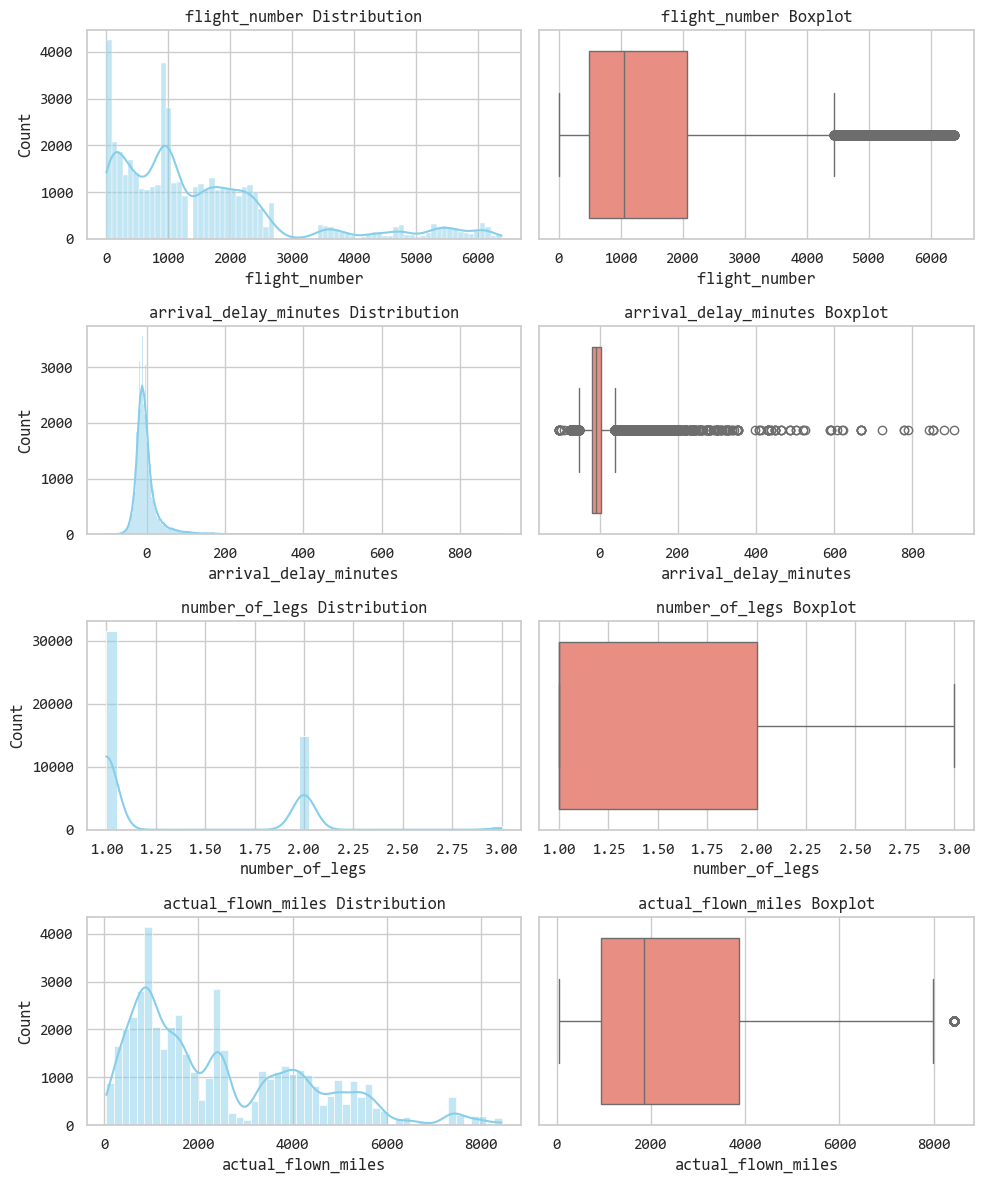

None

<Axes: >

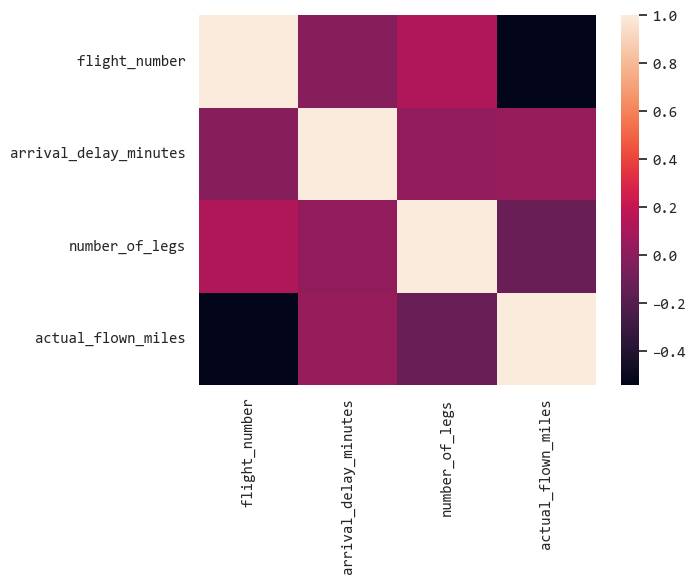

In [123]:
explore_numeric_cols(surveys_df)

- The columnms are mostly dominated by the type object, except for 4 columns only.

In [124]:
explore_object_cols(surveys_df)

origin_station_code destination_station_code record_locator  \
count                47074                    47074          47074   
unique                 213                      212          33095   
top                    IAX                      EWX         CEXXKB   
freq                  5758                     7058              6   

       scheduled_departure_date  \
count                     47074   
unique                       30   
top                   9/10/2022   
freq                       1872   

                                            question_text  score  \
count                                               47074  47074   
unique                                                  2     12   
top     How satisfied were you with the food & beverag...      2   
freq                                                34963   8250   

       satisfaction_type driver_sub_group1               driver_sub_group2  \
count              34963             47074                           47074   
unique                 2                 1                               2   
top         Dissatisfied   food & beverage  food and beverage satisfaction   
freq               22353             47074                           34963   

       arrival_delay_group  ... fleet_usage equipment_type_code ua_uax  \
count                47074  ...       47074               47074  47074   
unique                   2  ...           2                  40      2   
top         Early & Ontime  ...    Mainline                 37K     UA   
freq                 32868  ...       41628                6366  41628   

       haul_type departure_gate arrival_gate international_domestic_indicator  \
count      47074          46977        46547                            47074   
unique         3            656          692                                2   
top       Medium             A8         HOLD                         Domestic   
freq       26423            589          965                            29242   

       response_group media_provider      hub_spoke  
count           47074          45535          47074  
unique              3              4              2  
top            member      PANASONIC  hub departure  
freq            35382          24979          24343  

[4 rows x 27 columns]

============== origin_station_code ===============
IAX                                      5758
EWX                                      5589
DEX                                      4152
ORX                                      3981
SFX                                      3495
LAX                                      2044
LHX                                      1455
HNX                                      986
BOX                                      698
MCX                                      640

============ destination_station_code ============
EWX                                      7058
IAX                                      6821
ORX                                      4578
DEX                                      4027
SFX                                      4003
LAX                                      2035
LHX                                      1323
HNX                                      769
SAX                                      584
MCX                         

- Some `record_locator` values are repeated up to 6 times.
- `score` can contain values that aren't necessarily scores, they appear in significant numbers.
- `driver_sub_group1` has the same value repeated in all rows.
- `driver_sub_group2` and `question_text` match in unique values count and frequency.
- `cabin_name` only contain values retaled to the "Economy" `cabin_code_desc` value.
- `loyalty_program_level` has 3 instances of an outlier value "NBK".
- `generation` shares the same outlier instances ("NBK") as `loyalty_program_level`, plus an outlier value "Greatest".
- `response_group` also contains the same outlier value ("NBK") encountered twice so far.

flight_number                           0
origin_station_code                     0
destination_station_code                0
record_locator                          0
scheduled_departure_date                0
question_text                           0
score                                   0
satisfaction_type                   12111
driver_sub_group1                       0
driver_sub_group2                       0
arrival_delay_minutes                   0
arrival_delay_group                     0
cabin_code_desc                         0
cabin_name                          19980
entity                                  3
number_of_legs                          0
seat_factor_band                        0
loyalty_program_level               11616
generation                              0
fleet_type_description                  0
fleet_usage                             0
equipment_type_code                     0
ua_uax                                  0
actual_flown_miles                

<Axes: >

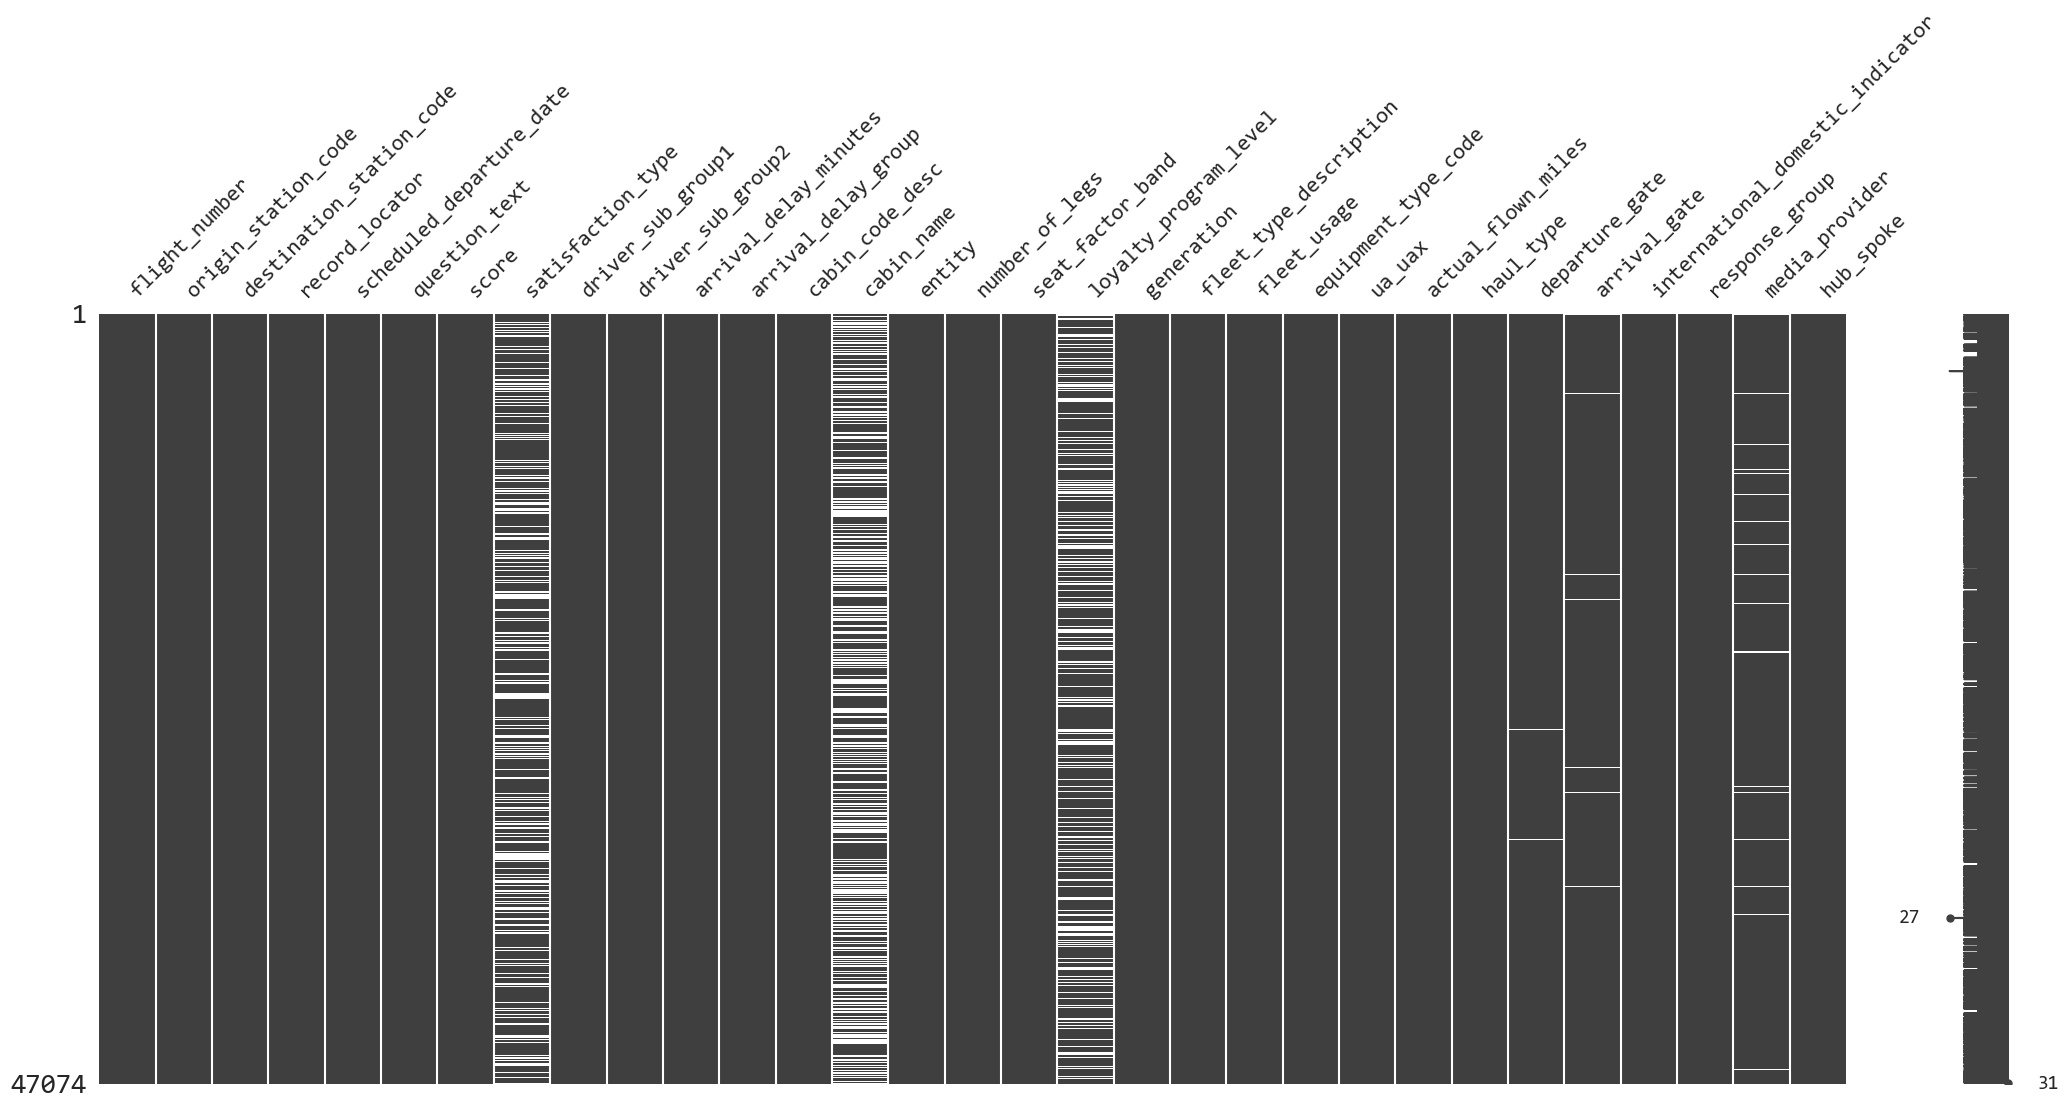

In [125]:
explore_na(surveys_df)

- The null `satisfaction_type` values have an equivalent frequency to one of `driver_sub_group2` unique values.
- `cabin_name` values only reflect one of the unique values in `cabin_code_desc`.
- `loyalty_program_level` null values should be related to `response_group`.

#### Surveys Table Data Cleaning

In [126]:
surveys_df.drop(columns=['driver_sub_group1'], inplace=True)
surveys_df = surveys_df[(surveys_df['loyalty_program_level'] != 'NBK') & (surveys_df['generation'] != 'Greatest')]

- `driver_sub_group2` was dropped as it contains just 1 single value, which is of very little help in analysis.

In [127]:
sub_vs_sats = pd.crosstab(surveys_df['driver_sub_group2'], surveys_df['satisfaction_type'], dropna=False)
display(sub_vs_sats)

sub_vs_ques = pd.crosstab(surveys_df['driver_sub_group2'], surveys_df['question_text'], dropna=False)
display(sub_vs_ques)

desc_vs_cabin = pd.crosstab(surveys_df['cabin_code_desc'], surveys_df['cabin_name'], dropna=False)
display(desc_vs_cabin)

resp_vs_loyalty = pd.crosstab(surveys_df['response_group'], surveys_df['loyalty_program_level'], dropna=False)
display(resp_vs_loyalty)

surveys_df = surveys_df[surveys_df['driver_sub_group2'] != 'comp']
surveys_df.drop(columns=['question_text', 'driver_sub_group2'], inplace=True)
surveys_df['cabin_name'] = surveys_df['cabin_name'].fillna(surveys_df['cabin_code_desc'])
surveys_df['loyalty_program_level'] = surveys_df['loyalty_program_level'].fillna('non-loyal')

satisfaction_type               Dissatisfied  Satisfied    NaN
driver_sub_group2                                             
comp                                       0          0  12110
food and beverage satisfaction         22349      12609      0

question_text                   How satisfied were you with the food & beverage served on your flight from [CITY] to [CITY]?  \
driver_sub_group2                                                                                                              
comp                                                                            0                                              
food and beverage satisfaction                                              34958                                              

question_text                   What item did you choose?  
driver_sub_group2                                          
comp                                                12110  
food and beverage satisfaction                          0

cabin_name           Economy  Economy Plus    NaN
cabin_code_desc                                  
Business                   0             0  18015
Economy                18435          8656      0
United Premium Plus        0             0   1962

loyalty_program_level  global services  non-elite  premier 1k  premier gold  \
response_group                                                                
member                             933      19278        4327          3359   
non-member                           1         53           7             3   

loyalty_program_level  premier platinum  premier silver    NaN  
response_group                                                  
member                             2633            4849      0  
non-member                            3               6  11616

- Pitting `cabin_code_desc` against `cabin_name` shows us that the latter does indeed only reflect the sub-categories of the "Economy" cabin code.
- In this case, we went ahead with setting the sub-category as the main category if it has no sub-categories.

flight_number                          0
origin_station_code                    0
destination_station_code               0
record_locator                         0
scheduled_departure_date               0
score                                  0
satisfaction_type                      0
arrival_delay_minutes                  0
arrival_delay_group                    0
cabin_code_desc                        0
cabin_name                             0
entity                                 3
number_of_legs                         0
seat_factor_band                       0
loyalty_program_level                  0
generation                             0
fleet_type_description                 0
fleet_usage                            0
equipment_type_code                    0
ua_uax                                 0
actual_flown_miles                     0
haul_type                              0
departure_gate                        93
arrival_gate                         514
international_do

<Axes: >

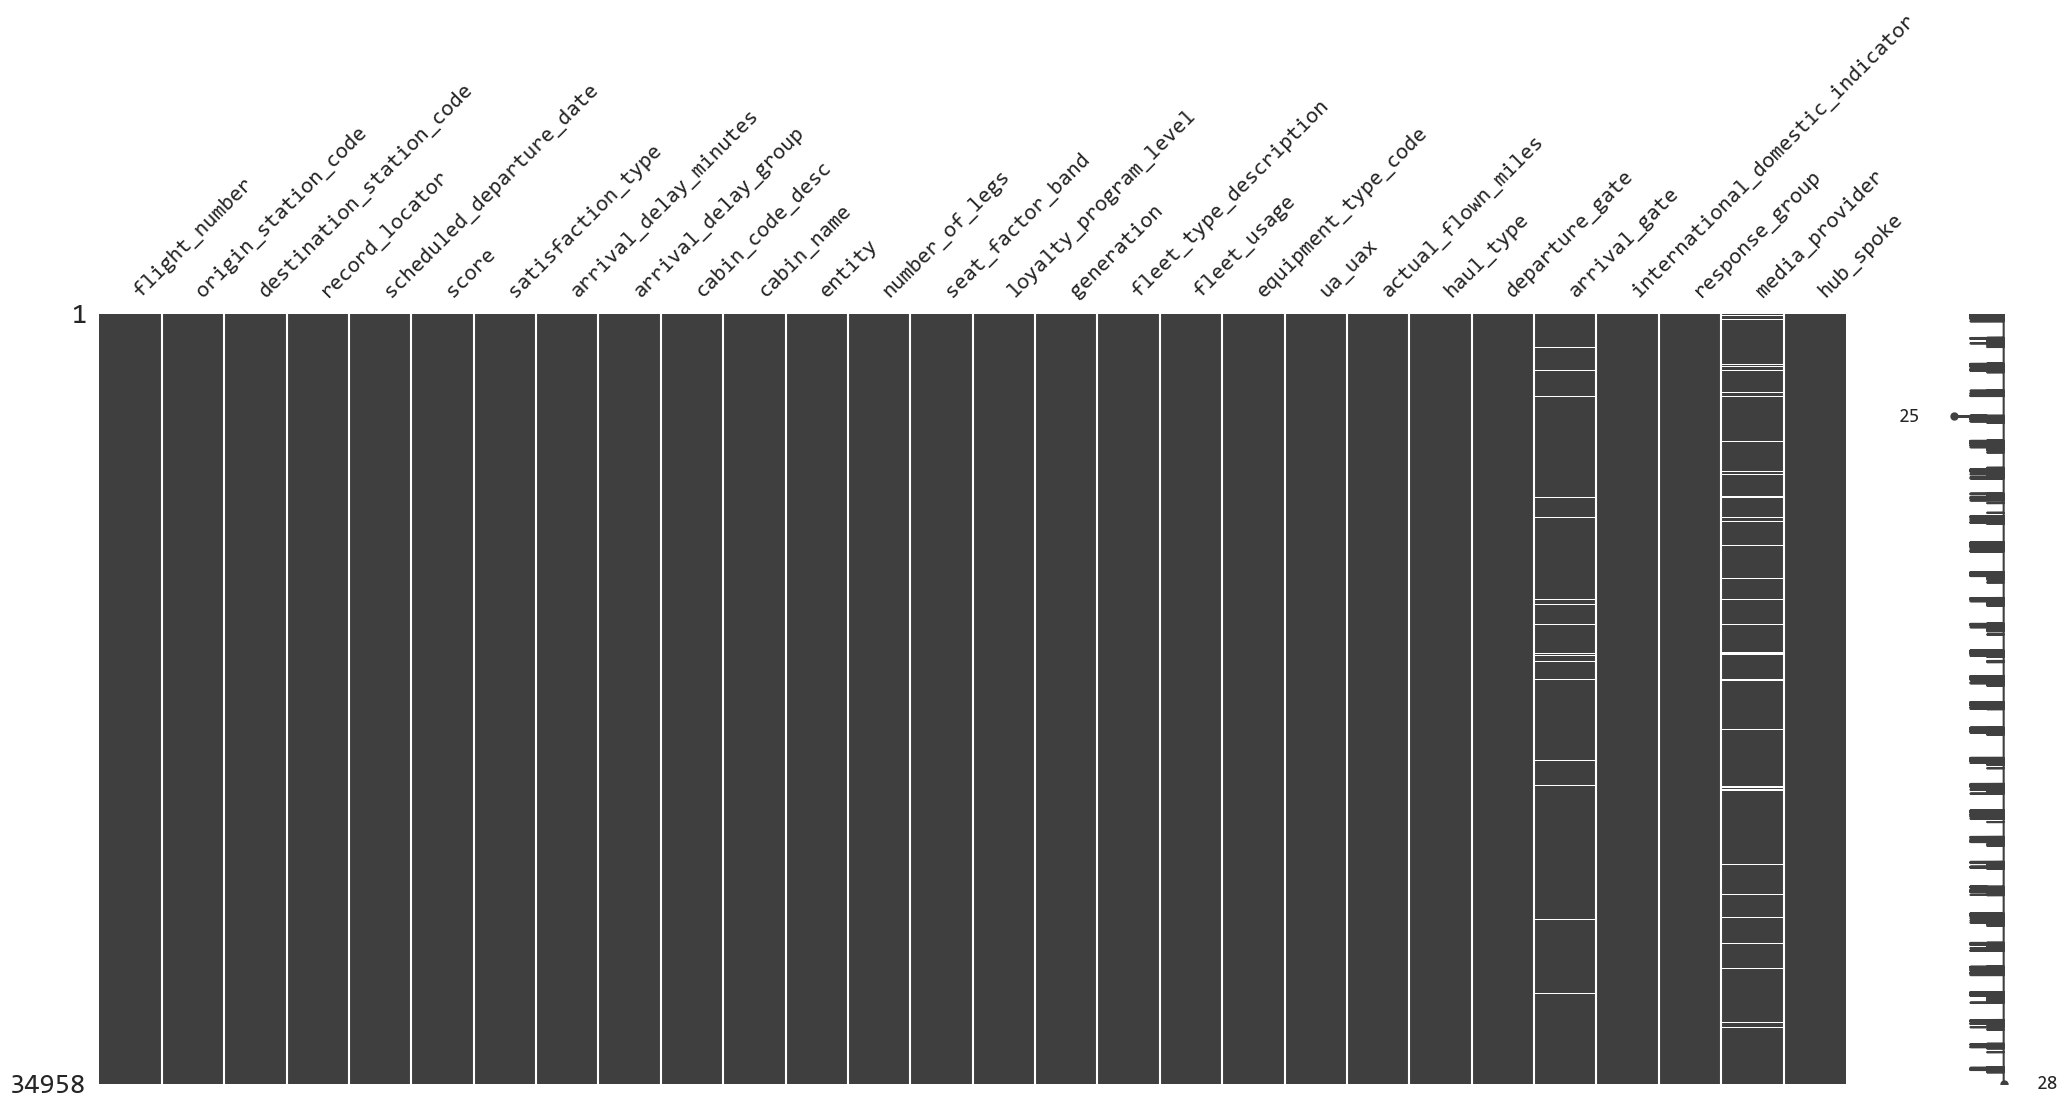

In [128]:
explore_na(surveys_df)

## Data Visualization

### Reviews Table Data Visualization

In [45]:
reviews_df = pd.read_csv('processed_dataset/airline_reviews.csv')

<Axes: ylabel='route'>

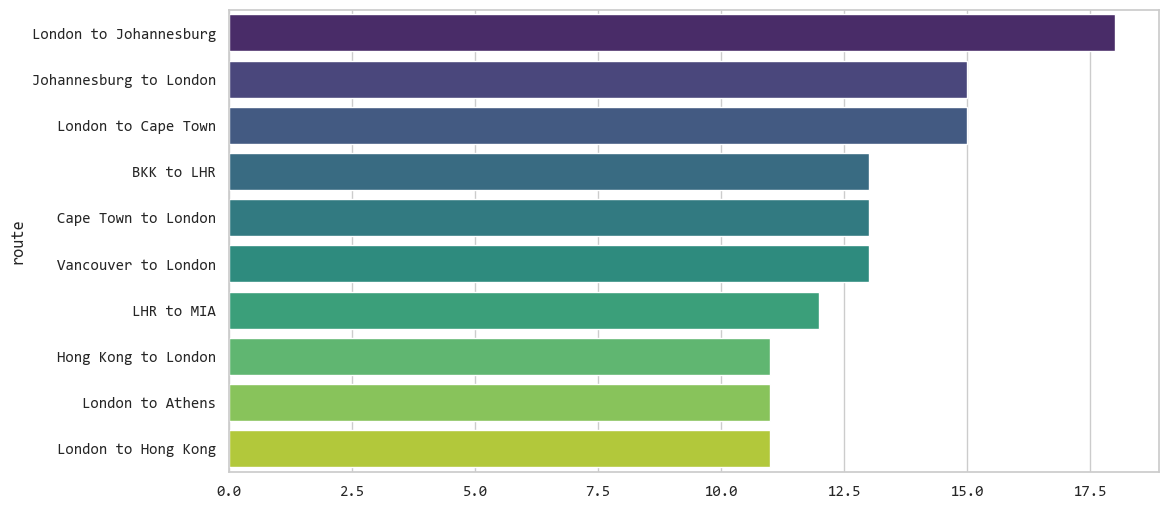

In [46]:
top_routes = reviews_df['route'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
display(sns.barplot(x=top_routes.values, y=top_routes.index, hue=top_routes.index, palette='viridis'))

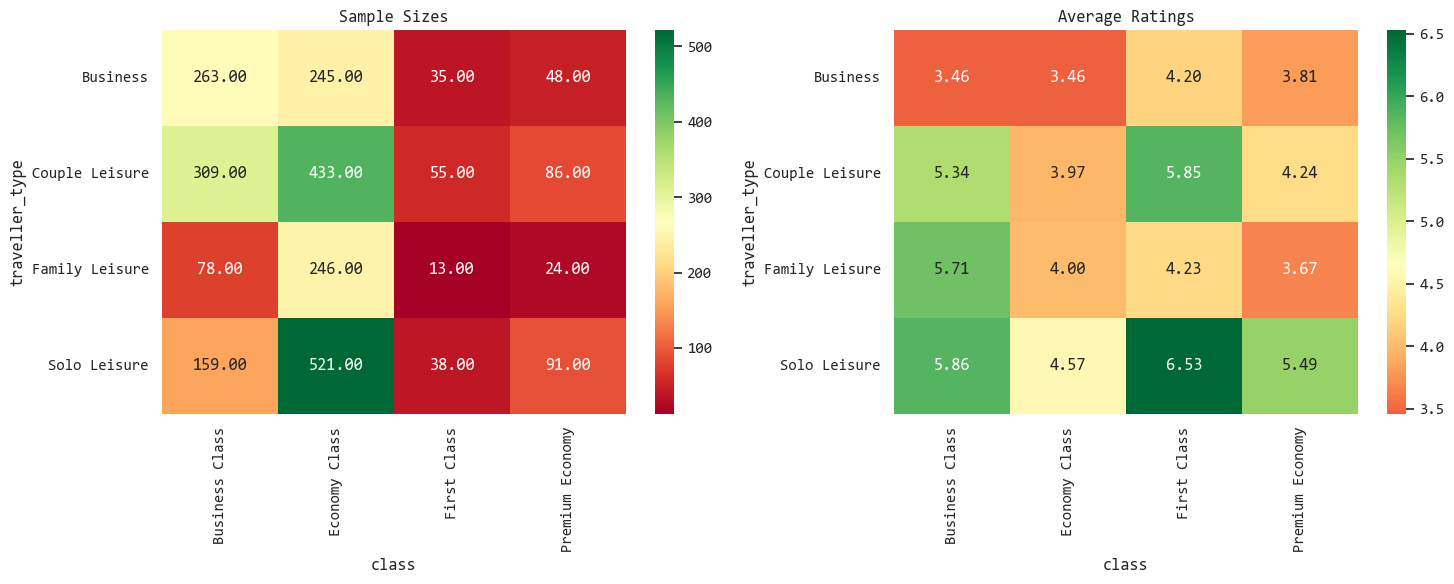

None

In [47]:
pivot_ratings = reviews_df.pivot_table(index='traveller_type', columns='class', values='rating', aggfunc=['mean', 'count'])

figure, (samples, ratings) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(pivot_ratings['count'], annot=True, fmt='.2f', cmap='RdYlGn', ax=samples)
samples.set_title('Sample Sizes')

sns.heatmap(pivot_ratings['mean'], annot=True, fmt='.2f', cmap='RdYlGn', center=pivot_ratings['mean'].mean().mean(), ax=ratings)
ratings.set_title('Average Ratings')

plt.tight_layout()
display(plt.show())

### Bookings Table Data Visualization

In [48]:
bookings_df = pd.read_csv('processed_dataset/passenger_bookings.csv')

<Axes: ylabel='route'>

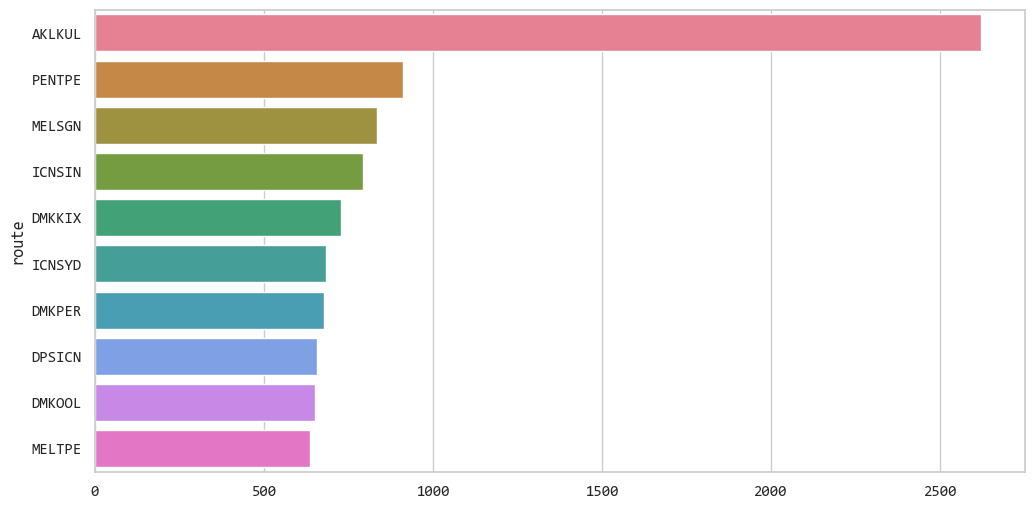

In [49]:
top_routes = bookings_df['route'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
display(sns.barplot(x=top_routes.values, y=top_routes.index, hue=top_routes.index))

<Axes: xlabel='flight_hour'>

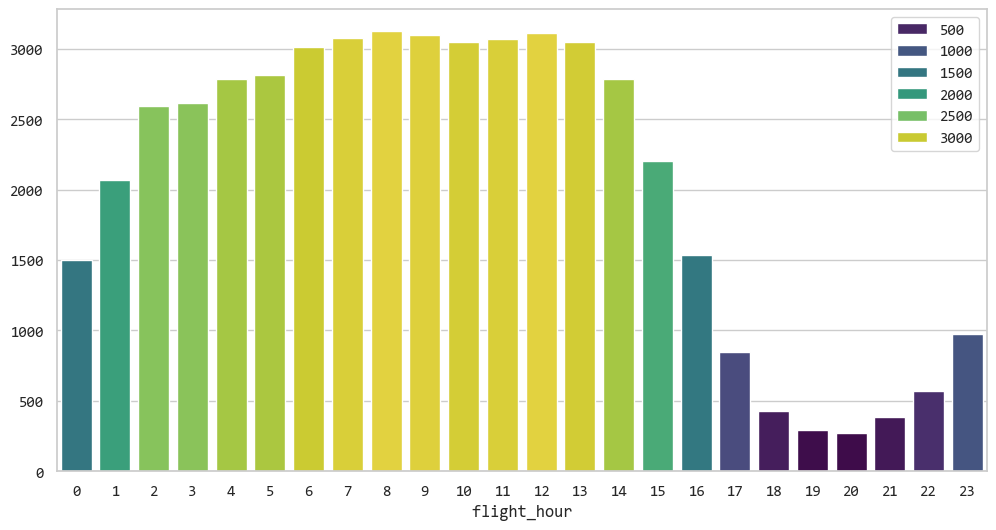

In [50]:
hours_dist = bookings_df['flight_hour'].value_counts()

plt.figure(figsize=(12, 6))
display(sns.barplot(x=hours_dist.index, y=hours_dist.values, hue=hours_dist.values, palette='viridis'))

## Prediction Model

### Feature Selection

In [51]:
reviews_df = pd.read_csv('processed_dataset/airline_reviews.csv')

In [52]:
X = reviews_df[['traveller_type', 'class', 'verified', 'sentiment']].copy()
y = reviews_df['rating'].copy()

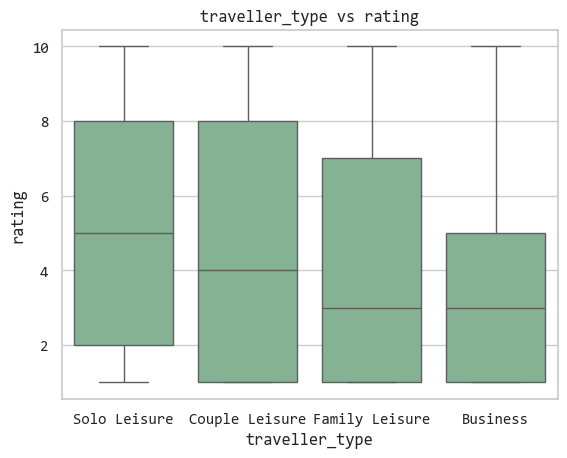

None

In [53]:
sns.boxplot(data=reviews_df, x='traveller_type', y='rating')
plt.title('traveller_type vs rating')
display(plt.show())

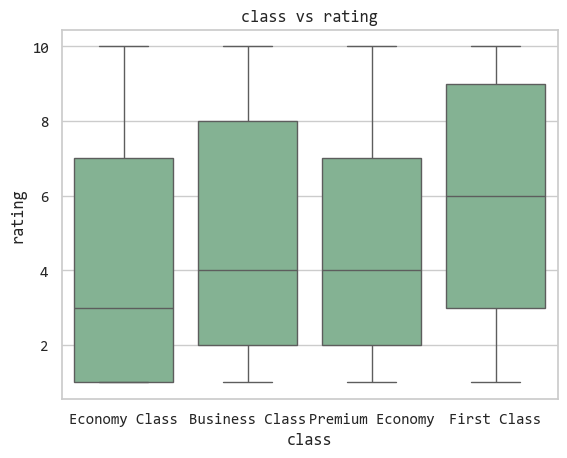

None

In [54]:
sns.boxplot(data=reviews_df, x='class', y='rating')
plt.title('class vs rating')
display(plt.show())

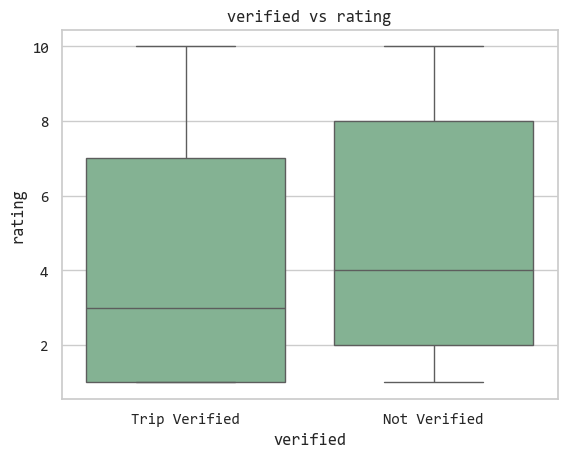

None

In [55]:
sns.boxplot(data=reviews_df, x='verified', y='rating')
plt.title('verified vs rating')
display(plt.show())

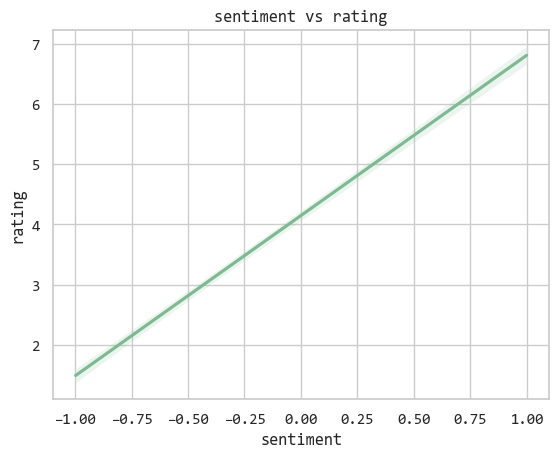

None

In [56]:
sns.regplot(data=reviews_df, x='sentiment', y='rating', scatter=False)
plt.title('sentiment vs rating')
display(plt.show())

### Feature Preparation

In [57]:
class_map = {value: index for index, value in enumerate(X['class'].value_counts().index.tolist())}
X['class'] = X['class'].map(class_map)

X_encoded = pd.get_dummies(X, drop_first=True)
y = (y >= 5).rename('satisfied')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

- Encoding is a crucial step that categorical features must go through before being fed to a predictive model.
- Encoding turns non-numeric values into numeric values using a specific strategy.
- Only `class` was label encoded due to its ordinal nature. Other categorical features underwent one-encoding for their nature that lacks ranking or order.
- - -
- Scaling is another necessary step that all columns need to pass by.
- Scaling ensures that values may not have a bigger weight for simply belonging to a bigger range.
- Features are standardized by removing the mean and scaling to unit variance.

In [58]:
background = shap.sample(X_train, 100, random_state=42)

lime_explainer = LimeTabularExplainer(X_train,
                                      feature_names=X_encoded.columns,
                                      class_names=['Dissatisfied', 'Satisfied'],
                                      discretize_continuous=True)

### Model Building

#### Model #01

##### Model #01 Architecture

In [59]:
model_01 = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

display(model_01.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

None

In [60]:
model_01.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall')])

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6726 - loss: 0.6476 - precision: 0.5668 - recall: 0.8946 - val_accuracy: 0.7565 - val_loss: 0.6072 - val_precision: 0.6711 - val_recall: 0.8389
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7861 - loss: 0.5714 - precision: 0.7009 - recall: 0.8447 - val_accuracy: 0.7849 - val_loss: 0.5527 - val_precision: 0.7109 - val_recall: 0.8333
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7955 - loss: 0.5180 - precision: 0.7171 - recall: 0.8376 - val_accuracy: 0.7872 - val_loss: 0.5097 - val_precision: 0.7103 - val_recall: 0.8444
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8067 - loss: 0.4775 - precision: 0.7306 - recall: 0.8462 - val_accuracy: 0.7920 - val_loss: 0.4830 - val_precision: 0.7170 - val_recall: 0.8444
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.4577 - precision: 0.7311 - recall: 0.8405 - val_accuracy: 0.7896 - val_loss: 0.4719 - val

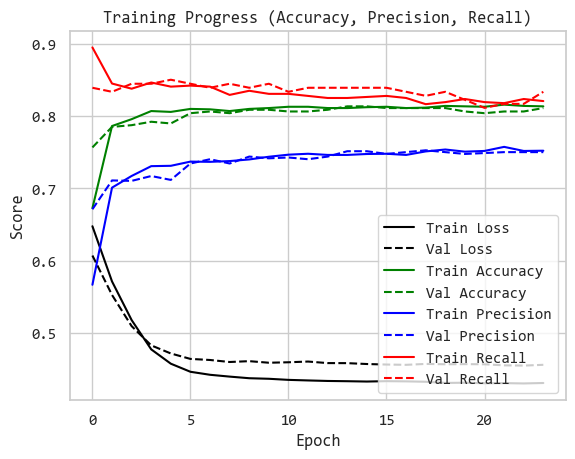

None

In [61]:
history_01 = model_01.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
])

explore_history(history_01)

##### Model #01 Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Loss: 0.4753740429878235
Accuracy: 0.7958412170410156
Precision: 0.7824427485466003
Recall: 0.80078125


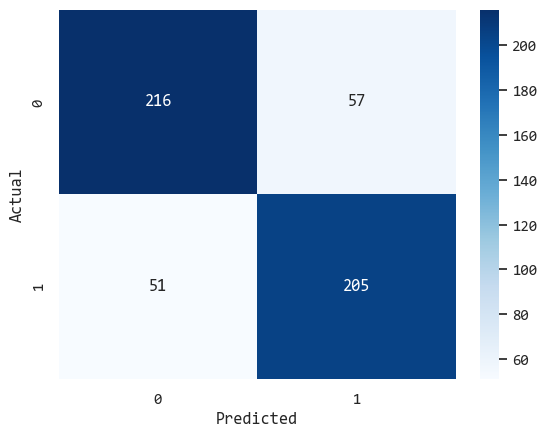

None

              precision    recall  f1-score   support

       False       0.81      0.79      0.80       273
        True       0.78      0.80      0.79       256

    accuracy                           0.80       529
   macro avg       0.80      0.80      0.80       529
weighted avg       0.80      0.80      0.80       529



In [62]:
evaluate_metrics(model_01, X_test, y_test)

##### Model #01 Explaination

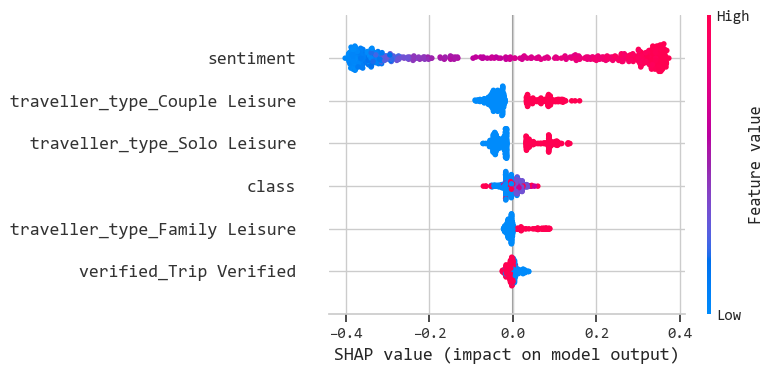

None

In [63]:
explainer_01 = shap.Explainer(model_01, background)
shap_01 = explainer_01(X_test)

display(shap.summary_plot(shap_01.values, X_test, feature_names=X_encoded.columns))

In [64]:
shap.plots.force(shap_01[0], feature_names=X_encoded.columns)

In [65]:
explanation = lime_explainer.explain_instance(X_test[0],
                                               wrap_predict(model_01.predict),
                                               num_features=len(X_encoded.columns))

display(HTML(explanation.as_html()))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


### Inference Function

In [66]:
def predict_satisfaction(traveller_type, class_, verification, review_content):
    df = pd.DataFrame([{
        'traveller_type': traveller_type,
        'class': class_,
        'verification': verification,
        'sentiment': review_content
    }])

    df['class'] = df['class'].map(class_map)
    df['sentiment'] = df['sentiment'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

    df_encoded = pd.get_dummies(df).reindex(columns=X_encoded.columns, fill_value=0)

    df_scaled = scaler.transform(df_encoded)

    return model_01.predict(df_scaled)[0][0]

pred_bad = predict_satisfaction('Solo Leisure', 'Economy Class', 'Not Verified', 'Poor food and lost luggage.')
print(f'Likelihood To Be Satisfied: {pred_bad}')

pred_good = predict_satisfaction('Family Leisure', 'Business Class', 'Verified', 'Awesome flight, awesome pilot and awesome food.')
print(f'Likelihood To Be Satisfied: {pred_good}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Likelihood To Be Satisfied: 0.11018463969230652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Likelihood To Be Satisfied: 0.7787367105484009
